# Code for the paper "Vaccination strategies when vaccines are scarce: Conflicts between reducing burden and avoiding the evolution of escape mutations"

In [2]:
import numpy as np
from math import *
import os
import sys
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.integrate import simps
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import matplotlib.ticker
%matplotlib inline

plt.rcParams['figure.figsize'] = (6.4, 4.8)
plt.rcParams['figure.dpi'] = 100

class FFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, fformat="%1.1f", offset=True, mathText=True):
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self, useOffset=offset, useMathText=mathText)
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
            self.format = '$%s$' % self.format

In [3]:
# WLOG, the population size is set to 1
N = 1
# Default parameter values
R0D = 1.2
R0HighD = 2
gammaD = 0.2
betaD = R0D * gammaD
I0D = 2.4e-3      # In Germany, there were 99,154 new detected cases in the 5 days before 01-01-2021 (you have to multiply by 2 to take into account the undetected cases) Source: https://www.worldometers.info/coronavirus/country/germany/
Rec0D = 4.2e-2    # In Germany 01-01-2021: 1,762,525 total cases (you have to multiply by 2 to take into account the undetected cases)
mu1D = 1e-6
mu_ratioD = 10
lD = N * 0.2 / 100 # There are 0.2% of the pop size doses available each day
lHighD = N * 2 / 100
wD = 20
w_min = 20
tau_max = 1 / w_min
xD = 0.5
yD = 0
TcD = 10
IcD = I0D / 10
VcD = 10

In [4]:
# Parameters for the numerical solution
tmax = 1000
nbSteps = 1000
tV = np.linspace(0, tmax, nbSteps + 1)
relativeTolerance = 1e-9
absoluteTolerance = 1e-9

tick_label_size = 15
fontsize = 17
fontsize_legend = 15

### The model

In [5]:
def model(t, xV, beta, gamma, l, tau, x, y):
    S = xV[0]
    VH = xV[1]
    VF = xV[2]
    I = xV[3]
    VI = xV[4]
    R = xV[5]
    if S < 0:
        #S = 0
        dSdt = 0
    else:
        dSdt = - (l - tau * VH)
    dSdt -= beta * S * (I + (1 - y) * VI) / N
    if S < 0:
        if VH < 0:
            #VH = 0
            dVHdt = 0
        else:
            dVHdt = - min(l, tau_max * VH)
    else:
        dVHdt = l - 2 * tau * VH
    dVHdt -= (1 - x) * beta * VH * (I + (1 - y) * VI) / N
    if S < 0:
        if VH < 0:
            dVFdt = 0
        else:
            dVFdt = min(l, tau_max * VH)
    else:
        dVFdt = tau * VH
    dIdt = (beta * S * (I + (1 - y) * VI) / N) - gamma * I
    dVIdt = ((1 - x) * beta * VH * (I + (1 - y) * VI) / N) - gamma * VI
    dRdt = gamma * I + gamma * VI
    syst = [dSdt, dVHdt, dVFdt, dIdt, dVIdt, dRdt]
    return syst

### Compute the metrics

In [6]:
def solve_and_plot(R0=R0D, gamma=gammaD, I0=I0D, Rec0=Rec0D, mu1=mu1D, mu_ratio=mu_ratioD, l=lD, w=wD, x=xD, y=yD,
                   isPlot=True, tmax_plot=300, log_scale=False, file_name="dynamics_default"):
    beta = R0 * gamma
    tau = 1 / w
    mu2 = mu1 * mu_ratio
    x0 = [(1 - I0 - Rec0) * N, 0, 0, I0 * N, 0, Rec0 * N]
    res = solve_ivp(model, [0, tmax], x0, t_eval=tV, rtol=relativeTolerance, atol=absoluteTolerance,
                    args=(beta, gamma, l, tau, x, y))
    if not res.success:
        print(res.message)
    sol = res.y

    if isPlot:
        labels=['$S$', '$V_H$', '$V_F$', '$I$', '$V_{H,I}$', '$R$']
        color_map = ['#006ddb', '#6db6ff', '#b6dbff', '#ff6db6', '#ffb6db', '#db6d00']
#         color_map = ['#b6dbff', '#6db6ff', '#006ddb', '#ffb6db', '#ff6db6', '#db6d00']
        line_styles = ['-', '--', ':', '-', '--', '-']
#         line_styles = [':', '--', '-', ':', '-', ':']
        if l > 0:
            indices = range(6)
        else:
            indices = [0, 3, 5]
        for i in indices:
            plt.plot(res.t[:tmax_plot], sol[i][:tmax_plot], label=labels[i], linewidth=3, color=color_map[i], linestyle=line_styles[i])
        plt.rc('xtick', labelsize=tick_label_size)
        plt.rc('ytick', labelsize=tick_label_size)
        plt.ylabel('Fraction', fontsize=fontsize)
        plt.xlabel('Days since start of vaccine roll-out', fontsize=fontsize)
#         plt.legend(fontsize=fontsize, bbox_to_anchor=(1.0, 1.0), loc='upper left', ncol=1)
        x_text_VH = res.t[np.argmax(sol[1,:tmax_plot])]
        y_text_VH = np.max(sol[1,:tmax_plot])
        if l > 0:
            if w == 20:
                x_text_VH -= 200
                y_text_VH += 0.03
                text_VH = "Few half-vaccinated"
            elif  w == 100:
#                 x_text_VH += 20
#                 y_text_VH -= 0.03
                x_text_VH -= 600
                y_text_VH -= 0.06
                text_VH = "Many half-vaccinated"
            plt.text(x_text_VH, y_text_VH, text_VH, color='#6db6ff', fontsize=15)
        x_text_R = tmax_plot
        y_text_R = np.max(sol[-1,:tmax_plot]) + 0.03
        text_R = "$R(\infty)=$" + str("%0.2f" % sol[-1][-1])
        plt.text(x_text_R, y_text_R, text_R, color='#db6d00', fontsize=15, ha='right')
        if log_scale:
            plt.yscale('log')
            plt.ylim(1e-5, 2)
        else:
            plt.ylim(-0.03, 1)
        plt.savefig('./Fig/dynamics/' + file_name + '.pdf', bbox_inches='tight')
            
    rec = simps(gamma * sol[3] + gamma * sol[4], x=res.t)
    recVacc = simps(gamma * sol[4], x=res.t)
    mut = simps(mu1 * sol[3] + mu2 * sol[4], x=res.t)
    mutVacc = simps(mu2 * sol[4], x=res.t)
    recS = simps(gamma * sol[3], x=res.t)
    mutS = simps(mu1 * sol[3], x=res.t)
    return rec, recVacc, mut, mutVacc, recS, mutS

### Plot a single trajectory

In [7]:
def dynamics(R0=R0D, gamma=gammaD, I0=I0D, Rec0=Rec0D, l=lD, w=wD, x=xD, y=yD,
             log_scale=False, tmax_plot=300, file_name="dynamics_default"):
    tau = 1 / w
    metrics = solve_and_plot(R0=R0, I0=I0, Rec0=Rec0, gamma=gamma, l=l, w=w, x=x, y=y,
                             log_scale=log_scale, tmax_plot=tmax_plot, file_name=file_name)
    
    print("Total burden: %.2e \nTotal number of mutants: %.2e" % (metrics[0], metrics[2]))

## Figure 1 b

Total burden: 2.50e-01 
Total number of mutants: 1.25e-06


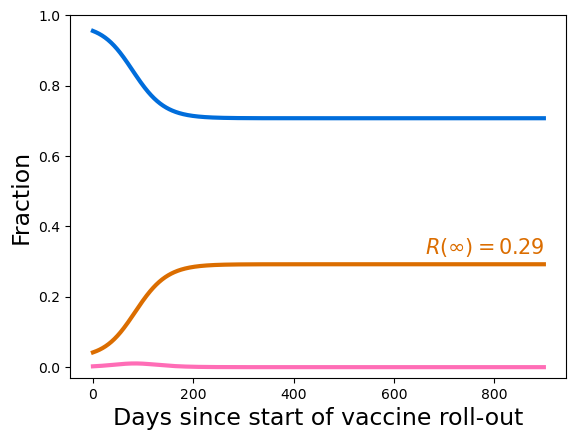

In [8]:
dynamics(log_scale=False, l=0, tmax_plot=900, file_name="dynamics_no_vaccine",
         x=1, y=1)

## Figure 1 c

Total burden: 1.17e-01 
Total number of mutants: 5.87e-07


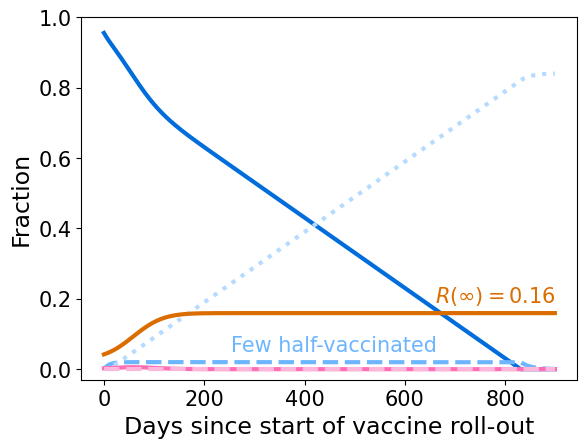

In [9]:
dynamics(log_scale=False, tmax_plot=900, file_name="dynamics",
         x=1, y=1)

## Figure 1 d

Total burden: 9.53e-02 
Total number of mutants: 4.76e-07


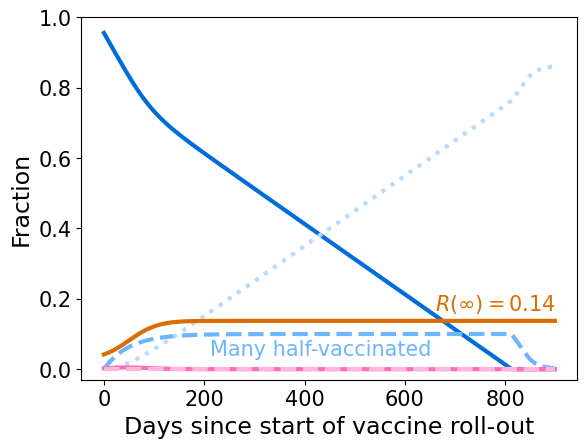

In [10]:
dynamics(log_scale=False, w=100, tmax_plot=900, file_name="dynamics_Omega100",
         x=1, y=1)

Generate legend

In [11]:
import pylab
labels=['$S$', '$V_H$', '$V_F$', '$I$', '$V_{H,I}$', '$R$']
color_map = ['#006ddb', '#6db6ff', '#b6dbff', '#ff6db6', '#ffb6db', '#db6d00']
line_styles = ['-', '--', ':', '-', '--', '-']
fig = pylab.figure()
figlegend = pylab.figure(figsize=(3,2))
ax = fig.add_subplot(111)
for i in range(len(labels)):
    lines = ax.plot(range(10), pylab.randn(10), label=labels[i],
                    linewidth=3, color=color_map[i], linestyle=line_styles[i])
figlegend.legend(ax.get_lines(), tuple(labels), 'center')
figlegend.savefig('./Fig/dynamics/dynamics_legend.pdf', bbox_inches='tight')
fig.clear()

<Figure size 640x480 with 0 Axes>

<Figure size 300x200 with 0 Axes>

In [12]:
# dynamics(R0=1.2, l=N * 0.2 / 100, file_name="dynamics_R2", tmax_plot=1)

In [13]:
# dynamics(R0=2, w=100, file_name="dynamics_R2_Omega100")

In [14]:
# dynamics(l=0, R0=2, file_name="dynamics_R2_no_vaccine")

### Plot the metrics for x or y fixed

In [15]:
def sus_trans(effect, constEffect=0, R0=R0D, gamma=gammaD, I0=I0D, Rec0=Rec0D, l=lD, mu1=mu1D, mu_ratio=mu_ratioD,
             name="default"):
    x_yV = np.linspace(0, 1, 3)
    wV = np.linspace(100, 20, 25)
    recoveredV = []
    recoveredSV = []
    recoveredVaccV = []
    mutV = []
    mutSV = []
    mutVaccV = []
    for x_y in x_yV:
        if effect == "susceptibility":
            x = x_y
            y = constEffect
        else:
            y = x_y
            x = constEffect
        tempRecovered = []
        tempRecoveredS = []
        tempRecoveredVacc = []
        tempMut = []
        tempMutS = []
        tempMutVacc = []
        for w in wV:
            metrics = solve_and_plot(R0=R0, I0=I0, Rec0=Rec0, gamma=gamma, l=l, w=w,
                                      x=x, y=y, mu1=mu1, mu_ratio=mu_ratio, isPlot=False)
            tempRecovered.append(metrics[0] * 100)
            tempRecoveredVacc.append(metrics[1] * 100)
            tempMut.append(metrics[2] * 1e6)
            tempMutVacc.append(metrics[3] * 1e6)
            tempRecoveredS.append(metrics[4] * 100)
            tempMutS.append(metrics[5] * 1e6)
        recoveredV.append(tempRecovered)
        recoveredVaccV.append(tempRecoveredVacc)
        recoveredSV.append(tempRecoveredS)
        mutV.append(tempMut)
        mutVaccV.append(tempMutVacc)
        mutSV.append(tempMutS)

    labels = ['0 (no effect)', '0.5', '1 (full effect)']
    line_styles = [':', '--', '-']
    if effect == "susceptibility":
        x_label = r"Efficacy for susceptibility $x$"
        color_map = ['k', '#fb9a99', '#e31a1c']
    else:
        x_label = r"Efficacy for transmissibility $y$"
        color_map = ['k', '#a6cee3', '#1f78b4']
    plt.rc('xtick', labelsize=tick_label_size)
    plt.rc('ytick', labelsize=tick_label_size)
#     min_burden = np.amin(np.array([recoveredV, recoveredSV, recoveredVaccV]))
    min_burden = 0
    max_burden = np.amax(np.array([recoveredV, recoveredSV, recoveredVaccV]))
#     min_mutant = np.amin(np.array([mutV, mutSV, mutVaccV]))
    min_mutant = 0
    max_mutant = np.amax(np.array([mutV, mutSV, mutVaccV]))
    min_burden -= (max_burden - min_burden) / 20
    max_burden += (max_burden - min_burden) / 20
    min_mutant -= (max_mutant - min_mutant) / 20
    max_mutant += (max_mutant - min_mutant) / 20
    path = './Fig/x_or_y/'

    fs = 17
    fformat = "%1.f"
    fformatM = "%1.1f"

    plt.figure(0)
    for i, x_y in enumerate(x_yV):
        plt.plot(wV, recoveredV[i], label=labels[i], linestyle=line_styles[i], color=color_map[i], linewidth=3)
    plt.ylabel('Burden $B$\n(in 1/100)', fontsize=fs)
    plt.xlabel('Time between injections $\omega$', fontsize=fs)
#     plt.gca().yaxis.set_major_formatter(FFormatter(fformat=fformat, offset=False, mathText=False))
#     plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    plt.yticks([0, 5, 10, 15])
    plt.ylim(min_burden, max_burden)
    plt.savefig(path + effect  + '_burden_' + name + '.pdf', bbox_inches='tight')

    plt.figure(1)
    for i, x_y in enumerate(x_yV):
        plt.plot(wV, recoveredSV[i], label = labels[i], linestyle=line_styles[i], color=color_map[i], linewidth=3)
    plt.ylabel('Burden of unvaccinated\n$B_S$ (in 1/100)', fontsize=fs)
    plt.xlabel('Time between injections $\omega$', fontsize=fs)
    plt.gca().yaxis.set_major_formatter(FFormatter(fformat=fformat, offset=False, mathText=False))
#     plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    plt.yticks([0, 5, 10, 15])
    plt.ylim(min_burden, max_burden)
    plt.savefig(path + effect  + '_burden_S_' + name + '.pdf', bbox_inches='tight')

    plt.figure(2)
    for i, x_y in enumerate(x_yV):
        plt.plot(wV, recoveredVaccV[i], label = labels[i], linestyle=line_styles[i], color=color_map[i], linewidth=3)
    plt.ylabel('Burden of half-vaccinated\n$B_H$ (in 1/100)', fontsize=fs)
    plt.xlabel('Time between injections $\omega$', fontsize=fs)
    plt.gca().yaxis.set_major_formatter(FFormatter(fformat=fformat, offset=False, mathText=False))
#     plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    plt.yticks([0, 5, 10, 15])
    plt.ylim(min_burden, max_burden)
    legend = plt.legend(title = x_label, loc='upper left', fontsize=fontsize_legend, frameon=False)
    legend.get_title().set_fontsize(fontsize_legend)
    plt.savefig(path + effect  + '_burden_H_' + name + '.pdf', bbox_inches='tight')

    plt.figure(3)
    for i, x_y in enumerate(x_yV):
        plt.plot(wV, mutV[i], label=labels[i], linestyle=line_styles[i], color=color_map[i], linewidth=3)
    plt.ylabel('Escape risk $M$\n(in 1/Million)', fontsize=fs)
    plt.xlabel('Time between injections $\omega$', fontsize=fs)
#     plt.gca().yaxis.set_major_formatter(FFormatter(fformat=fformatM, offset=False, mathText=False))
#     plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    plt.yticks([0, 0.5, 1, 1.5])
    plt.ylim(min_mutant, max_mutant)
    plt.savefig(path + effect  + '_mutants_' + name + '.pdf', bbox_inches='tight')

    plt.figure(4)
    for i, x_y in enumerate(x_yV):
        plt.plot(wV, mutSV[i], label = labels[i], linestyle=line_styles[i], color=color_map[i], linewidth=3)
    plt.ylabel('Escape risk of unvaccinated\n$M_S$ (in 1/Million)', fontsize=fs)
    plt.xlabel('Time between injections $\omega$', fontsize=fs)
#     plt.gca().yaxis.set_major_formatter(FFormatter(fformat=fformatM, offset=False, mathText=False))
#     plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    plt.yticks([0, 0.5, 1, 1.5])
    plt.ylim(min_mutant, max_mutant)
    plt.savefig(path + effect  + '_mutants_S_' + name + '.pdf', bbox_inches='tight')

    plt.figure(5)
    for i, x_y in enumerate(x_yV):
        plt.plot(wV, mutVaccV[i], label = labels[i], linestyle=line_styles[i], color=color_map[i], linewidth=3)
    plt.ylabel('Escape risk of half-vaccinated\n$M_H$ (in 1/Million)', fontsize=fs)
    plt.xlabel('Time between injections $\omega$', fontsize=fs)
#     plt.gca().yaxis.set_major_formatter(FFormatter(fformat=fformatM, offset=False, mathText=False))
#     plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    plt.yticks([0, 0.5, 1, 1.5])
    plt.ylim(min_mutant, max_mutant)
    legend = plt.legend(title = x_label, loc='upper left', fontsize=fontsize_legend, frameon=False)
    legend.get_title().set_fontsize(fontsize_legend)
    plt.savefig(path + effect  + '_mutants_H_' + name + '.pdf', bbox_inches='tight')

## Figure 2 a-f

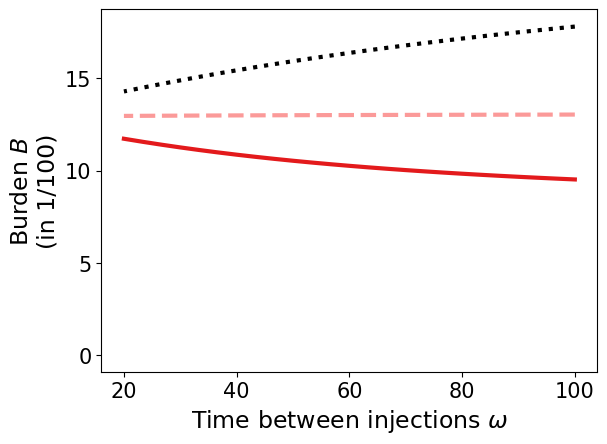

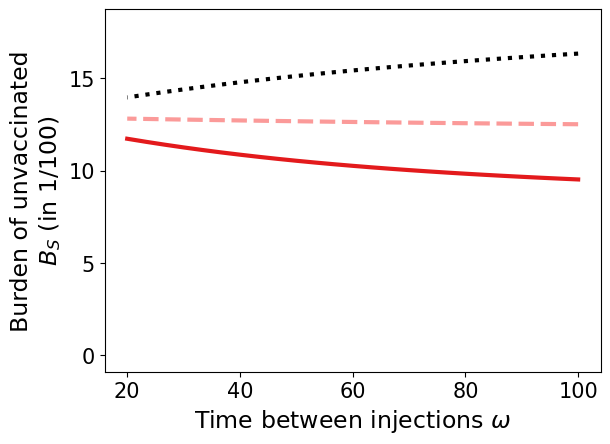

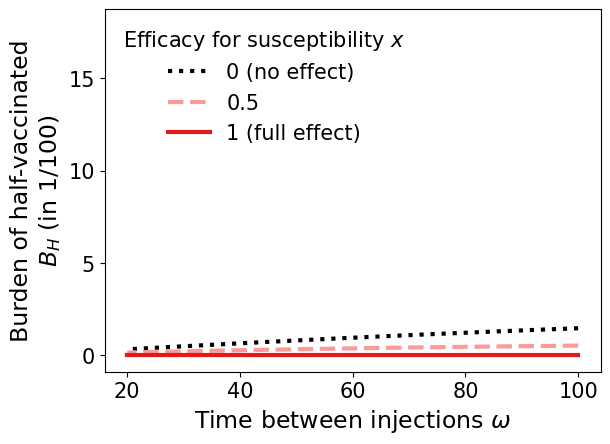

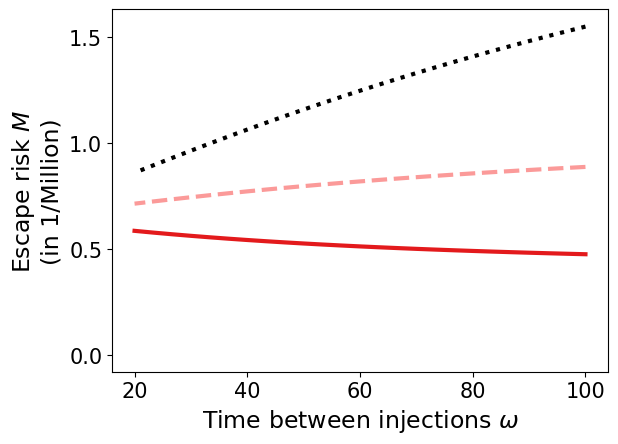

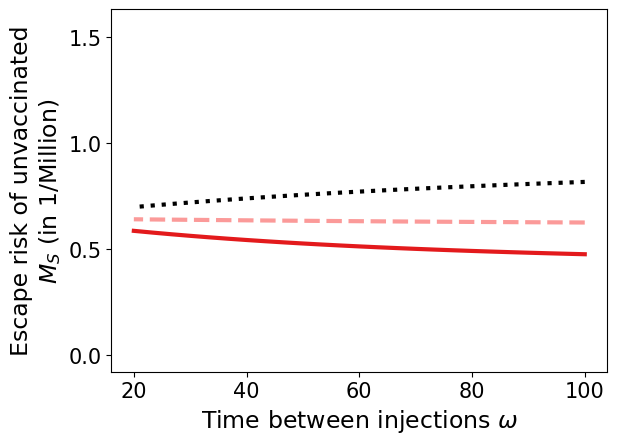

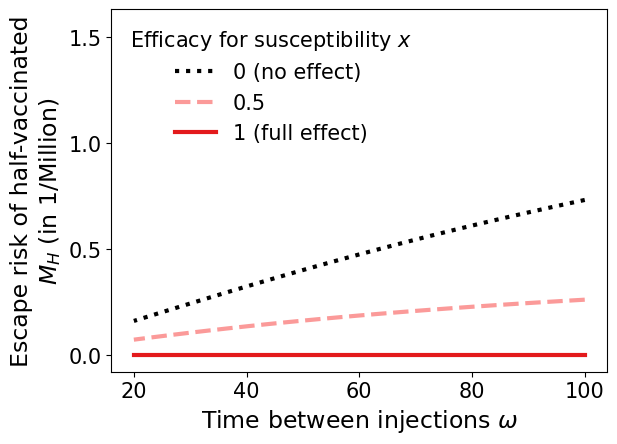

In [16]:
sus_trans(effect="susceptibility")

## Figure 2 g-l

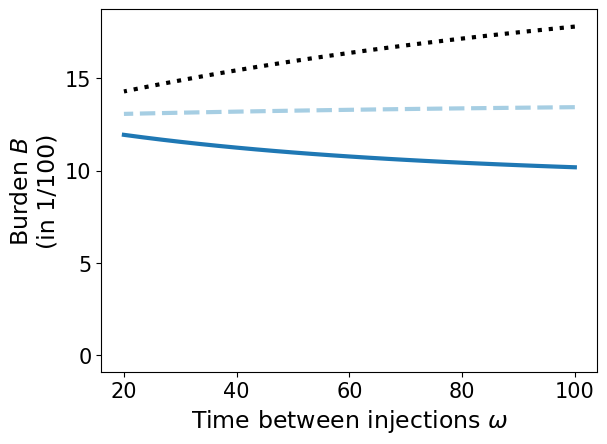

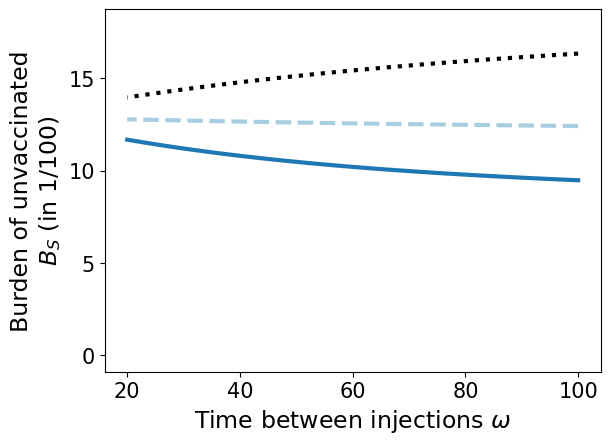

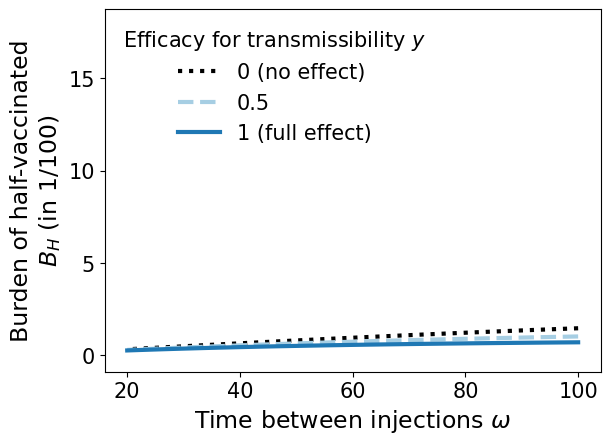

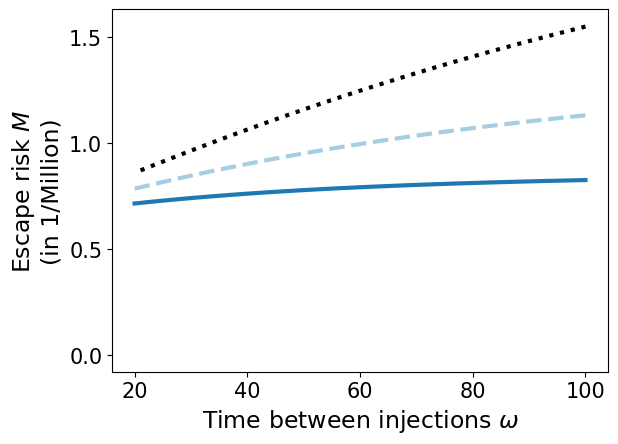

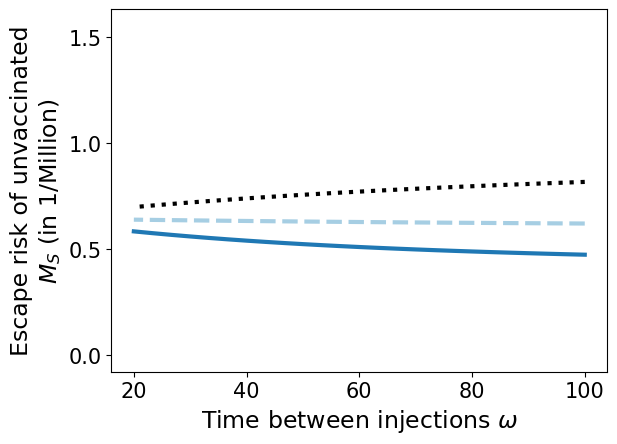

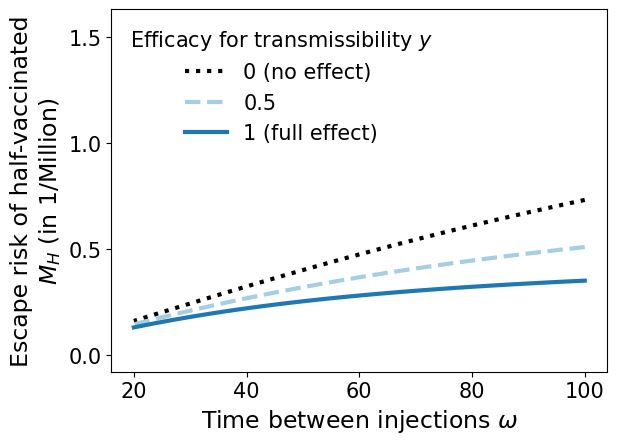

In [17]:
sus_trans(effect="transmissibility")

### Plot the metrics varying x and y

In [18]:
def compute_abs_ticks(min, max, nb_max_ticks, nb_digits):
    ticks = []
    step = (max - min) / (nb_max_ticks - 1)
    step = ceil(step * 10**nb_digits) / 10**nb_digits
    t = 0
    while t <= max:
        t += step
        if t >= min:
            ticks.append(t)
    ticks = np.sort(np.array(ticks))
    return ticks

def compute_diff_ticks(min, max, nb_max_ticks):
    is_transparent_tick = False
    ticks = [0]
    step = (max - min) / (nb_max_ticks - 1)
    step = ceil(step * 100) / 100
    t = 0
    while t >= min:
        t -= step
        ticks.append(t)
    t = 0
    while t <= max:
        t += step
        ticks.append(t)
    if step > - min:
        # ticks.append(step / 2)
        ticks.append(min)
        is_transparent_tick = True
    ticks = np.sort(np.array(ticks))
    return ticks, is_transparent_tick

In [19]:
def plot_heatmap(R0s=[R0D, R0HighD], gamma=gammaD, I0=I0D, Rec0=Rec0D, ls=[lD, lHighD], mu1=mu1D,
                 mu_ratios=[0.1, 1, 10], folder="", name=""):
    if folder != "":
        folder = folder + "/"
    if name != "":
        name = "_" + name
        
    xStep = 20    #20
    xV = np.linspace(0, 1, xStep)
    yV = np.linspace(0, 1, xStep)
    XV, YV = np.meshgrid(xV, yV)
    wV = [20, 100]
    minW = min(wV)
    maxW = max(wV)  
    plt.rc('xtick', labelsize=tick_label_size)
    plt.rc('ytick', labelsize=tick_label_size)
    count_fig = 0
    
    R0_l_list = []
    for R0 in R0s:
        R0_l_list.append([R0, ls[0]])
    for l in ls[1:]:
        R0_l_list.append([R0s[0], l])
    nb_param = len(R0_l_list)
    
    for mu_ratio in mu_ratios:
        minWRecoveredV = np.zeros((nb_param, xStep, xStep))
        maxWRecoveredV = np.zeros((nb_param, xStep, xStep))
        minWMutV = np.zeros((nb_param, xStep, xStep))
        maxWMutV = np.zeros((nb_param, xStep, xStep))
        for n, R0_l in enumerate(R0_l_list):
            R0 = R0_l[0]
            l = R0_l[1]
            for i, y in enumerate(yV):
                for j, x in enumerate(xV):
                    minRecovered = sys.float_info.max
                    minMut = sys.float_info.max
                    # optWRecovered = wV[0]
                    # optWMut = wV[0]
                    for w in wV:
                        metrics = solve_and_plot(R0=R0, I0=I0, Rec0=Rec0, gamma=gamma, l=l, w=w,
                                                  x=x, y=y, mu1=mu1, mu_ratio=mu_ratio, isPlot=False)
                        if w == minW:
                            minWRecoveredV[n, i, j] = metrics[0] * 100
                            minWMutV[n, i, j] = metrics[2] * 1e6
                        if w == maxW:
                            maxWRecoveredV[n, i, j] = metrics[0] * 100
                            maxWMutV[n, i, j] = metrics[2] * 1e6


        if mu_ratio == mu_ratioD:
            # Absolute_values of B and M for default values of R0 and l
            data = [maxWRecoveredV[0], minWRecoveredV[0], maxWMutV[0], minWMutV[0]]
            for i, d in enumerate(data):
                if i <= 1:
                    path = './Fig/' + folder + 'absolute/burden_Omega' + str(wV[i]) + name + '.pdf'
                    vmax = max(np.amax(np.array(maxWRecoveredV[0])), np.amax(np.array(minWRecoveredV[0])))
                    vmin = min(np.amin(np.array(maxWRecoveredV[0])), np.amin(np.array(minWRecoveredV[0])))
                    cmap = cm.viridis
                    bar_title = "$B$ (in 1/100)"
                    nb_digits = 1
                    fformat = "%1.1f"
                else:
                    path = './Fig/' + folder + 'absolute/mutants_Omega' + str(wV[i-2]) + name + '.pdf'
                    vmax = max(np.amax(np.array(maxWMutV[0])), np.amax(np.array(minWMutV[0])))
                    vmin = min(np.amin(np.array(maxWMutV[0])), np.amin(np.array(minWMutV[0])))
                    cmap = cm.plasma
                    bar_title = "$M$ (in 1/Million)"
                    nb_digits = 2
                    fformat = "%1.2f"
           
                plt.figure(count_fig)
                count_fig += 1
                levels = np.linspace(vmin, vmax, 20)
#                 ticks = np.linspace(vmin, vmax, 6)
                ticks = compute_abs_ticks(vmin, vmax, 6, nb_digits)
                plt.pcolormesh(XV, YV, d, shading='gouraud', cmap=cmap, vmin=vmin, vmax=vmax)
                bar = plt.colorbar(ticks=ticks, extend='both')
                bar.ax.set_title(bar_title, pad=0, loc='right', fontsize=fontsize)
                fformat = "%1." + str(nb_digits) + "f"
                bar.ax.yaxis.set_major_formatter(FFormatter(fformat=fformat))
                plt.xlabel(r"Efficacy for susceptibility $x$", fontsize=fontsize)
                plt.ylabel(r"Efficacy for transmissibility $y$", fontsize=fontsize)
#                 plt.text(0.95, -0.15, 'no effect', fontsize=tick_label_size, color='grey')
#                 plt.text(-0.27, 0.97, 'no\neffect', fontsize=tick_label_size, color='grey')
#                 plt.text(-0.25, -0.15, 'full effect', fontsize=tick_label_size, color='grey')
                plt.savefig(path, bbox_inches='tight')
                print(path)


        # Differences
        diffRecoveredV = maxWRecoveredV - minWRecoveredV
        diffMutV = maxWMutV - minWMutV
        max_B = np.amax(np.array(diffRecoveredV))
        min_B = np.amin(np.array(diffRecoveredV))
        max_M = np.amax(np.array(diffMutV))
        min_M = np.amin(np.array(diffMutV))

        for n, R0_l in enumerate(R0_l_list):
            R0 = R0_l[0]
            l = R0_l[1]
            diff_name = ""
            if mu_ratio != mu_ratioD:
                diff_name = "_MuRatio" + str(('%f' % mu_ratio).rstrip('0').rstrip('.')).replace('.', '')
            if R0 != R0D:
                diff_name = diff_name + "_R" + str(('%f' % R0).rstrip('0').rstrip('.')).replace('.', '')
            if l != lD:
                diff_name = diff_name + "_Lambda" + str(('%f' % (100*l)).rstrip('0').rstrip('.')).replace('.', '')
            if mu_ratio == mu_ratioD:
                path = './Fig/' + folder + 'diff/burden' + diff_name + name + '.pdf'
                plt.figure(count_fig)
                count_fig += 1
    #             ticks, is_transparent_tick = compute_diff_ticks(np.amin(np.array(diffRecoveredV)), vmax_B, 7)
                ticks, is_transparent_tick = compute_diff_ticks(min_B, max_B, 7)
    #             divnorm = colors.TwoSlopeNorm(vmin=-vmax_B, vcenter=0, vmax=vmax_B)
                divnorm = colors.TwoSlopeNorm(vmin=-max_B, vcenter=0, vmax=max_B)
    #             plt.contourf(XV, YV, diffRecoveredV[n], 20, norm=divnorm, cmap=cm.PRGn, extend='max')
                plt.contourf(XV, YV, diffRecoveredV[n], levels=np.linspace(min_B, max_B, 50), norm=divnorm, cmap=cm.PRGn, extend='max')
                bar = plt.colorbar(ticks=ticks)
                bar.ax.set_title('$\Delta B$ (in 1/100)', pad=0, loc='right', fontsize=fontsize)
                bar.ax.yaxis.set_major_formatter(FFormatter(fformat="%1.2f"))
                bar.ax.plot([-1, 1], [0, 0], 'k:')
                plt.contour(XV, YV, diffRecoveredV[n], 0, colors='k', linestyles='dashed')
                plt.xlabel(r"Efficacy for susceptibility $x$", fontsize=fontsize)
                plt.ylabel(r"Efficacy for transmissibility $y$", fontsize=fontsize)
#                 plt.text(0.95, -0.15, 'no effect', fontsize=tick_label_size, color='grey')
#                 plt.text(-0.27, 0.97, 'no\neffect', fontsize=tick_label_size, color='grey')
#                 plt.text(-0.25, -0.15, 'full effect', fontsize=tick_label_size, color='grey')
                plt.text(0.65, 0.85, 'Delay the\n$2^{nd}$ dose', fontsize=18, color='black', va='center')
                plt.text(0.1, 0.15, 'Do not\ndelay', fontsize=18, color='black', va='center')
                if is_transparent_tick:
                    bar.ax.yaxis.get_major_ticks()[0].tick2line.set_markersize(0)
                    bar.ax.get_yticklabels()[0].set_alpha(0)
                plt.savefig(path, bbox_inches='tight')
                print(path)

            path = './Fig/' + folder + 'diff/mutants' + diff_name + name + '.pdf'
            plt.figure(count_fig)
            count_fig += 1
    #         ticks, is_transparent_tick = compute_diff_ticks(np.amin(np.array(diffMutV)), vmax_M, 7)
            ticks, is_transparent_tick = compute_diff_ticks(min_M, max_M, 7)
    #         divnorm = colors.TwoSlopeNorm(vmin=-vmax_M, vcenter=0, vmax=vmax_M)
            divnorm = colors.TwoSlopeNorm(vmin=-max_M, vcenter=0, vmax=max_M)
    #         plt.contourf(XV, YV, diffMutV[n], 20, norm=divnorm, cmap=cm.BrBG, extend='max')
            plt.contourf(XV, YV, diffMutV[n], levels=np.linspace(min_M, max_M, 50), norm=divnorm, cmap=cm.BrBG, extend='max')
            bar = plt.colorbar(ticks=ticks)
            bar.ax.set_title('$\Delta M$ (in 1/Million)', pad=0, loc='right', fontsize=fontsize)
            bar.ax.yaxis.set_major_formatter(FFormatter(fformat="%1.2f"))
            bar.ax.plot([-1, 1], [0, 0], 'k:')
            if not (mu_ratio == 0.1 and R0 == 2):
#             if name != "MuRatio01_R2":
                plt.contour(XV, YV, diffMutV[n], 0, colors='k', linestyles='dashed')
            plt.xlabel(r"Efficacy for susceptibility $x$", fontsize=fontsize)
            plt.ylabel(r"Efficacy for transmissibility $y$", fontsize=fontsize)
#             plt.text(0.95, -0.15, 'no effect', fontsize=tick_label_size, color='grey')
#             plt.text(-0.27, 0.97, 'no\neffect', fontsize=tick_label_size, color='grey')
#             plt.text(-0.25, -0.15, 'full effect', fontsize=tick_label_size, color='grey')
#             if mu_ratio <= 1 or (mu_ratio == 10 and R0 == R0D and l == lD):
            if mu_ratio <= 1 or (R0 == R0D and l == lD):
                plt.text(0.65, 0.85, 'Delay the\n$2^{nd}$ dose', fontsize=18, color='black', va='center')
            if not (mu_ratio == 0.1 and (R0 != R0D or l != lD)):
                plt.text(0.1, 0.15, 'Do not\ndelay', fontsize=18, color='black', va='center')
            if is_transparent_tick:
                bar.ax.yaxis.get_major_ticks()[0].tick2line.set_markersize(0)
                bar.ax.get_yticklabels()[0].set_alpha(0)
            plt.savefig(path, bbox_inches='tight')
            print(path)

## Figures 3 and 4

./Fig/diff/mutants_MuRatio01.pdf
./Fig/diff/mutants_MuRatio01_R2.pdf
./Fig/diff/mutants_MuRatio01_Lambda2.pdf
./Fig/diff/mutants_MuRatio1.pdf
./Fig/diff/mutants_MuRatio1_R2.pdf
./Fig/diff/mutants_MuRatio1_Lambda2.pdf
./Fig/absolute/burden_Omega20.pdf
./Fig/absolute/burden_Omega100.pdf
./Fig/absolute/mutants_Omega20.pdf
./Fig/absolute/mutants_Omega100.pdf
./Fig/diff/burden.pdf
./Fig/diff/mutants.pdf
./Fig/diff/burden_R2.pdf
./Fig/diff/mutants_R2.pdf
./Fig/diff/burden_Lambda2.pdf
./Fig/diff/mutants_Lambda2.pdf


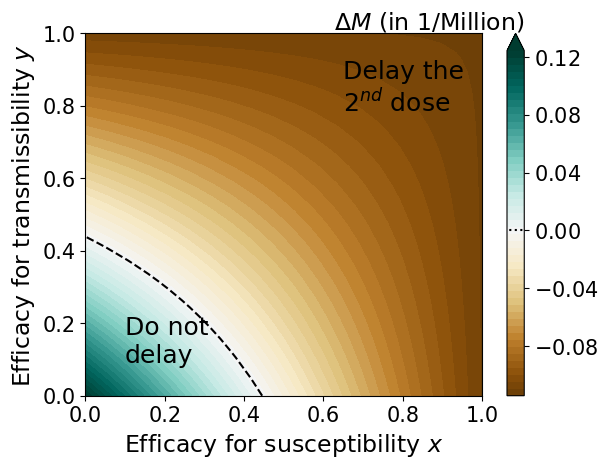

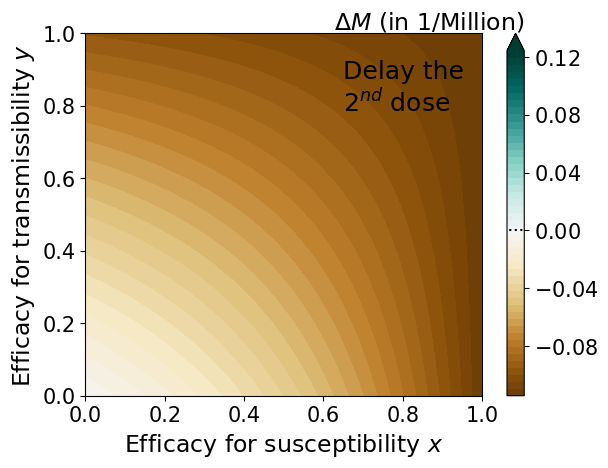

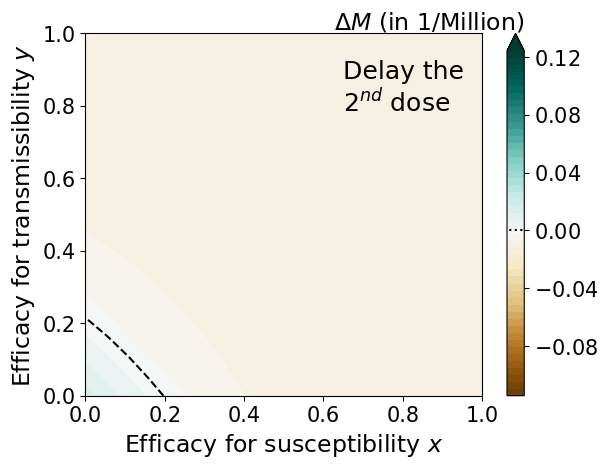

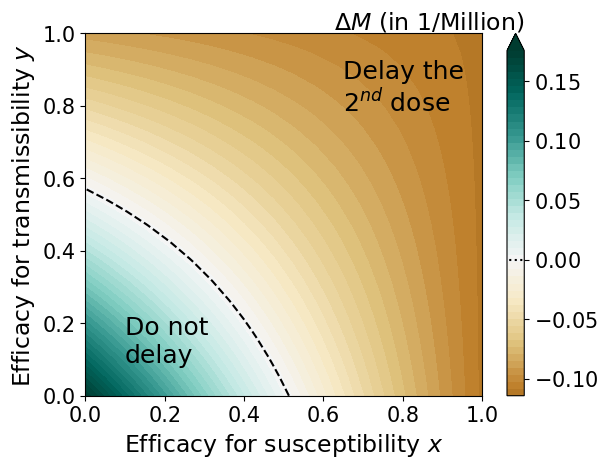

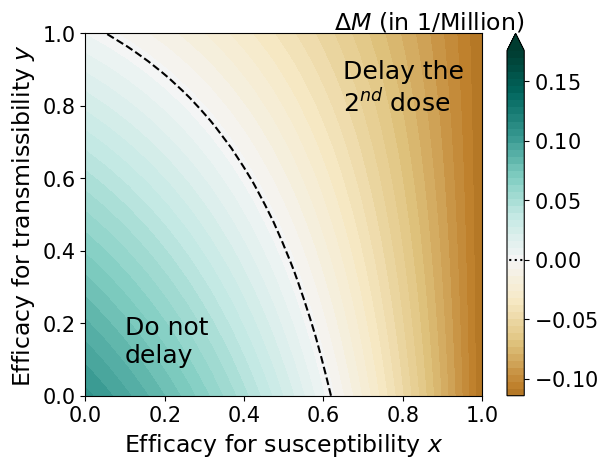

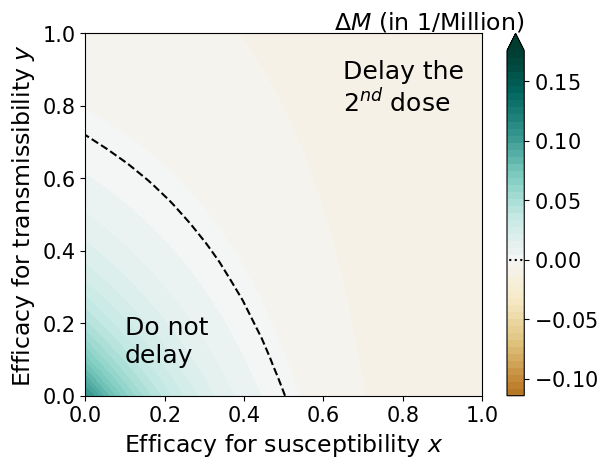

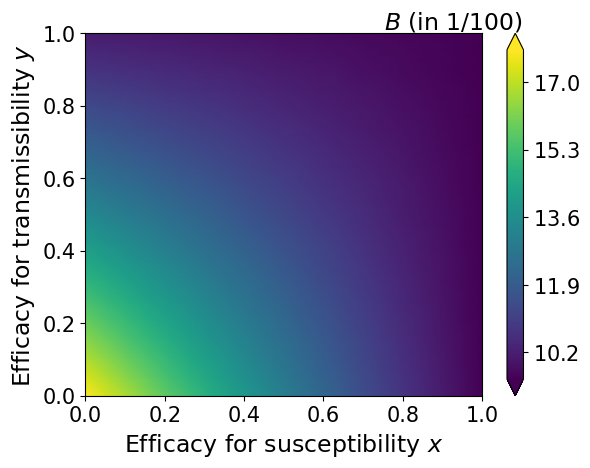

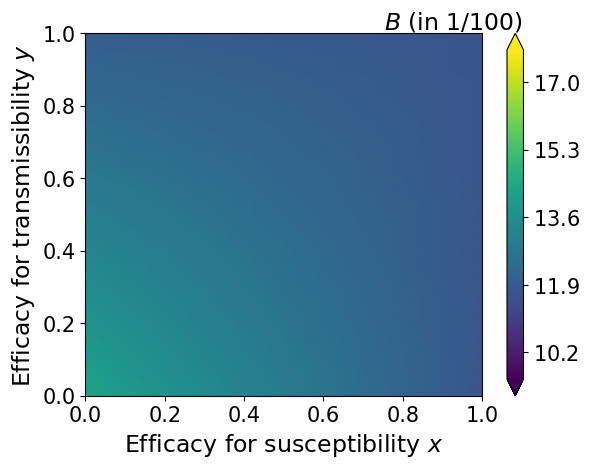

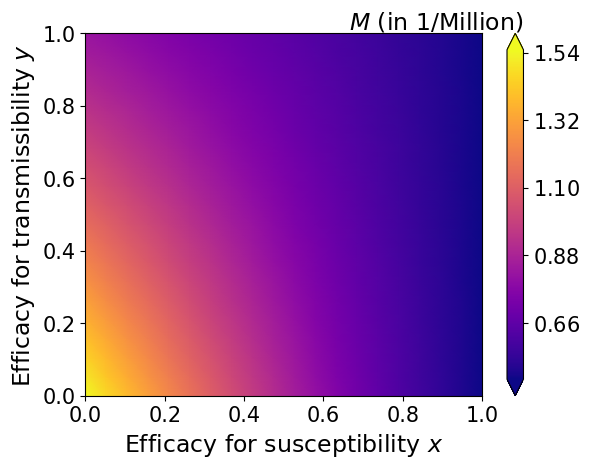

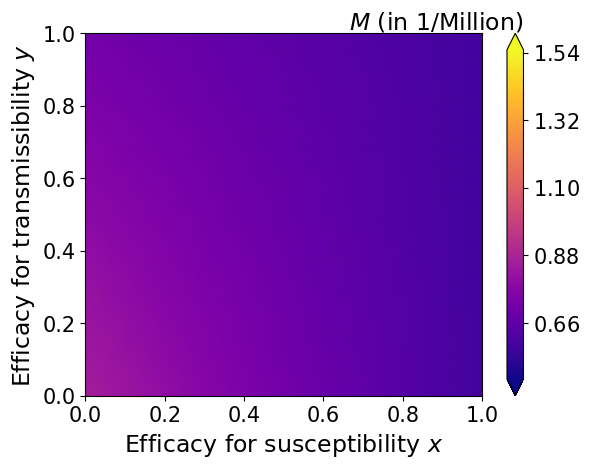

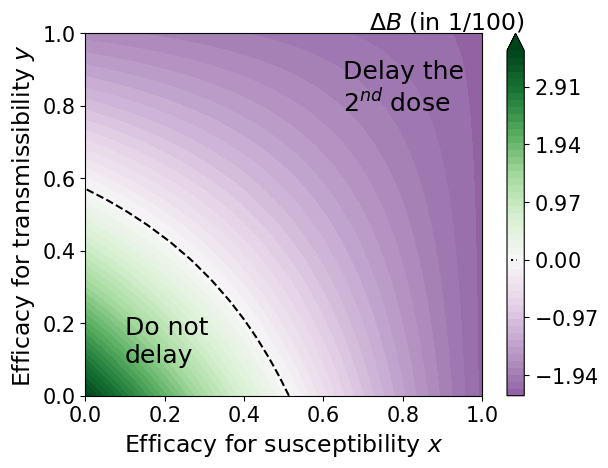

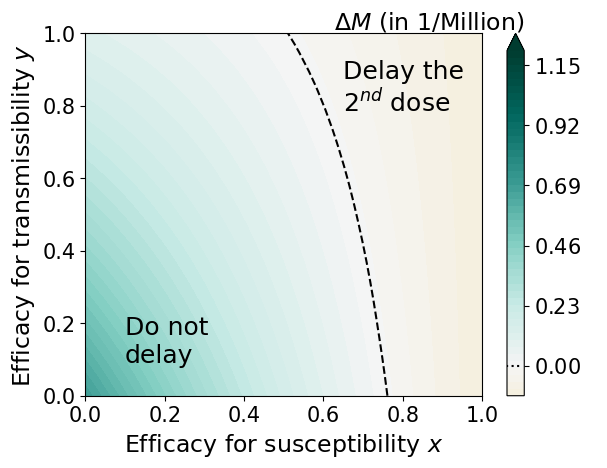

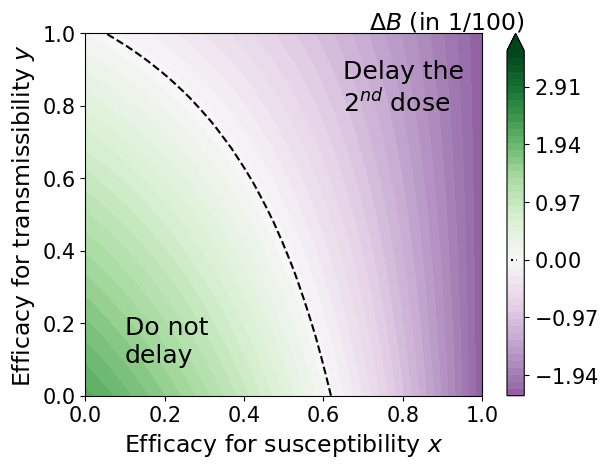

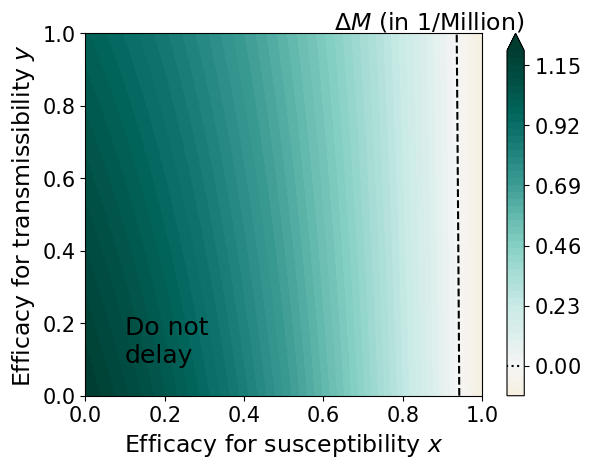

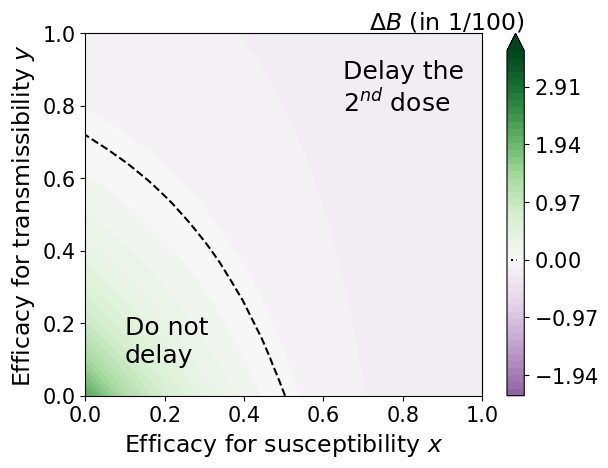

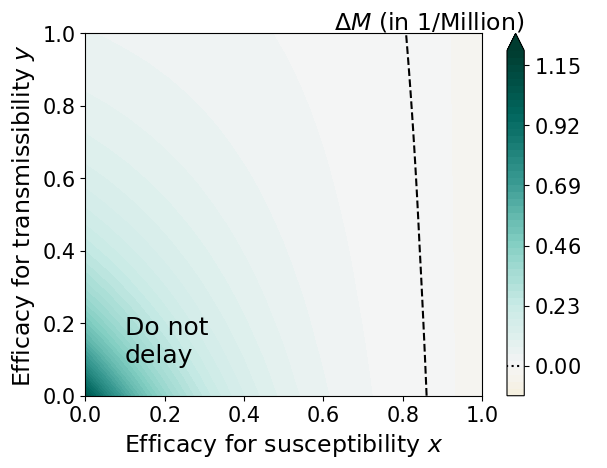

In [20]:
plot_heatmap()

## Compare scenario 1 and 2

In [21]:
def plot_heatmap_init(R0=R0D, gamma=gammaD, I0s=[I0D, 1e-6], Rec0s=[Rec0D, 0], l=lD, mu1=mu1D,
                 mu_ratios=[mu_ratioD], folder="", name=""):
    if folder != "":
        folder = folder + "/"
    if name != "":
        name = "_" + name
        
    xStep = 20    #20
    xV = np.linspace(0, 1, xStep)
    yV = np.linspace(0, 1, xStep)
    XV, YV = np.meshgrid(xV, yV)
    wV = [20, 100]
    minW = min(wV)
    maxW = max(wV)  
    plt.rc('xtick', labelsize=tick_label_size)
    plt.rc('ytick', labelsize=tick_label_size)
    count_fig = 0
    
    I0_Rec0_list = []
    for i in range(len(I0s)):
        I0_Rec0_list.append([I0s[i], Rec0s[i]])
    nb_param = len(I0_Rec0_list)
    
    for mu_ratio in mu_ratios:
        minWRecoveredV = np.zeros((nb_param, xStep, xStep))
        maxWRecoveredV = np.zeros((nb_param, xStep, xStep))
        minWMutV = np.zeros((nb_param, xStep, xStep))
        maxWMutV = np.zeros((nb_param, xStep, xStep))
        for n, I0_Rec0 in enumerate(I0_Rec0_list):
            I0 = I0_Rec0[0]
            Rec0 = I0_Rec0[1]
            for i, y in enumerate(yV):
                for j, x in enumerate(xV):
                    minRecovered = sys.float_info.max
                    minMut = sys.float_info.max
                    # optWRecovered = wV[0]
                    # optWMut = wV[0]
                    for w in wV:
                        metrics = solve_and_plot(R0=R0, I0=I0, Rec0=Rec0, gamma=gamma, l=l, w=w,
                                                  x=x, y=y, mu1=mu1, mu_ratio=mu_ratio, isPlot=False)
                        if w == minW:
                            minWRecoveredV[n, i, j] = metrics[0] * 100
                            minWMutV[n, i, j] = metrics[2] * 1e6
                        if w == maxW:
                            maxWRecoveredV[n, i, j] = metrics[0] * 100
                            maxWMutV[n, i, j] = metrics[2] * 1e6

        # Differences
        diffRecoveredV = maxWRecoveredV - minWRecoveredV
        diffMutV = maxWMutV - minWMutV
        max_B = np.amax(np.array(diffRecoveredV))
        min_B = np.amin(np.array(diffRecoveredV))
        max_M = np.amax(np.array(diffMutV))
        min_M = np.amin(np.array(diffMutV))

        for n, I0_Rec0 in enumerate(I0_Rec0_list):
            I0 = I0_Rec0[0]
            Rec0 = I0_Rec0[1]
            diff_name = ""
            if mu_ratio != mu_ratioD:
                diff_name = "_MuRatio" + str(('%f' % mu_ratio).rstrip('0').rstrip('.')).replace('.', '')
            if I0 != I0D:
                diff_name = diff_name + "_I0" + str(I0)
            if Rec0 != Rec0D:
                diff_name = diff_name + "_Rec0" + str(('%f' % Rec0).rstrip('0').rstrip('.')).replace('.', '')
            if mu_ratio == mu_ratioD:
                path = './Fig/' + folder + 'initial_conditions/burden' + diff_name + name + '.pdf'
                plt.figure(count_fig)
                count_fig += 1
                max_B = np.amax(np.array(diffRecoveredV[n]))
                min_B = np.amin(np.array(diffRecoveredV[n]))
    #             ticks, is_transparent_tick = compute_diff_ticks(np.amin(np.array(diffRecoveredV)), vmax_B, 7)
                ticks, is_transparent_tick = compute_diff_ticks(min_B, max_B, 7)
    #             divnorm = colors.TwoSlopeNorm(vmin=-vmax_B, vcenter=0, vmax=vmax_B)
                divnorm = colors.TwoSlopeNorm(vmin=-max_B, vcenter=0, vmax=max_B)
    #             plt.contourf(XV, YV, diffRecoveredV[n], 20, norm=divnorm, cmap=cm.PRGn, extend='max')
                plt.contourf(XV, YV, diffRecoveredV[n], levels=np.linspace(min_B, max_B, 50), norm=divnorm, cmap=cm.PRGn, extend='max')
                bar = plt.colorbar(ticks=ticks)
                bar.ax.set_title('$\Delta B$ (in 1/100)', pad=0, loc='right', fontsize=fontsize)
                bar.ax.yaxis.set_major_formatter(FFormatter(fformat="%1.2f"))
                bar.ax.plot([-1, 1], [0, 0], 'k:')
                plt.contour(XV, YV, diffRecoveredV[n], 0, colors='k', linestyles='dashed')
                plt.xlabel(r"Efficacy for susceptibility $x$", fontsize=fontsize)
                plt.ylabel(r"Efficacy for transmissibility $y$", fontsize=fontsize)
#                 plt.text(0.95, -0.15, 'no effect', fontsize=tick_label_size, color='grey')
#                 plt.text(-0.27, 0.97, 'no\neffect', fontsize=tick_label_size, color='grey')
#                 plt.text(-0.25, -0.15, 'full effect', fontsize=tick_label_size, color='grey')
                plt.text(0.65, 0.85, 'Delay the\n$2^{nd}$ dose', fontsize=18, color='black', va='center')
                plt.text(0.1, 0.15, 'Do not\ndelay', fontsize=18, color='black', va='center')
                if is_transparent_tick:
                    bar.ax.yaxis.get_major_ticks()[0].tick2line.set_markersize(0)
                    bar.ax.get_yticklabels()[0].set_alpha(0)
                plt.savefig(path, bbox_inches='tight')
                print(path)

            path = './Fig/' + folder + 'initial_conditions/mutants' + diff_name + name + '.pdf'
            plt.figure(count_fig)
            count_fig += 1
            max_M = np.amax(np.array(diffMutV[n]))
            min_M = np.amin(np.array(diffMutV[n]))
    #         ticks, is_transparent_tick = compute_diff_ticks(np.amin(np.array(diffMutV)), vmax_M, 7)
            ticks, is_transparent_tick = compute_diff_ticks(min_M, max_M, 7)
    #         divnorm = colors.TwoSlopeNorm(vmin=-vmax_M, vcenter=0, vmax=vmax_M)
            divnorm = colors.TwoSlopeNorm(vmin=-max_M, vcenter=0, vmax=max_M)
    #         plt.contourf(XV, YV, diffMutV[n], 20, norm=divnorm, cmap=cm.BrBG, extend='max')
            plt.contourf(XV, YV, diffMutV[n], levels=np.linspace(min_M, max_M, 50), norm=divnorm, cmap=cm.BrBG, extend='max')
            bar = plt.colorbar(ticks=ticks)
            bar.ax.set_title('$\Delta M$ (in 1/Million)', pad=0, loc='right', fontsize=fontsize)
            bar.ax.yaxis.set_major_formatter(FFormatter(fformat="%1.2f"))
            bar.ax.plot([-1, 1], [0, 0], 'k:')
            if not (mu_ratio == 0.1 and R0 == 2):
#             if name != "MuRatio01_R2":
                plt.contour(XV, YV, diffMutV[n], 0, colors='k', linestyles='dashed')
                plt.xlabel(r"Efficacy for susceptibility $x$", fontsize=fontsize)
                plt.ylabel(r"Efficacy for transmissibility $y$", fontsize=fontsize)
#             plt.text(0.95, -0.15, 'no effect', fontsize=tick_label_size, color='grey')
#             plt.text(-0.27, 0.97, 'no\neffect', fontsize=tick_label_size, color='grey')
#             plt.text(-0.25, -0.15, 'full effect', fontsize=tick_label_size, color='grey')
            
            plt.text(0.65, 0.85, 'Delay the\n$2^{nd}$ dose', fontsize=18, color='black', va='center')
            plt.text(0.1, 0.15, 'Do not\ndelay', fontsize=18, color='black', va='center')
                
            if is_transparent_tick:
                bar.ax.yaxis.get_major_ticks()[0].tick2line.set_markersize(0)
                bar.ax.get_yticklabels()[0].set_alpha(0)
            plt.savefig(path, bbox_inches='tight')
            print(path)

## Figure 5

./Fig/initial_conditions/burden.pdf
./Fig/initial_conditions/mutants.pdf
./Fig/initial_conditions/burden_I01e-06_Rec00.pdf
./Fig/initial_conditions/mutants_I01e-06_Rec00.pdf


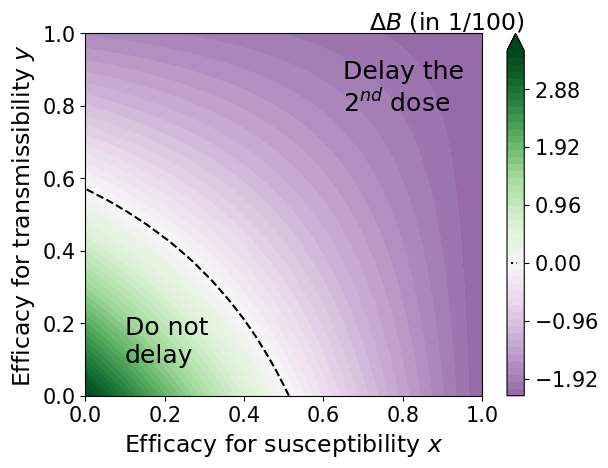

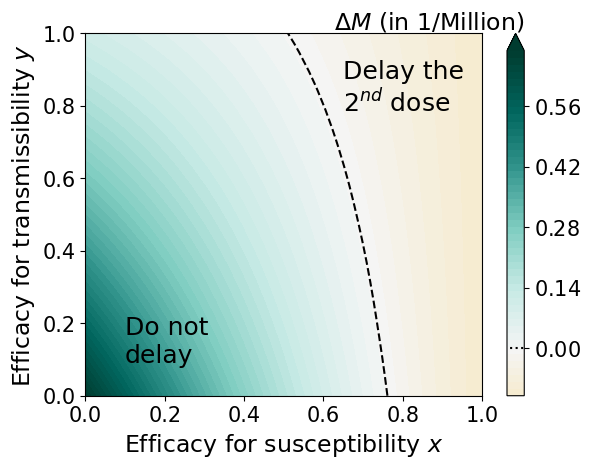

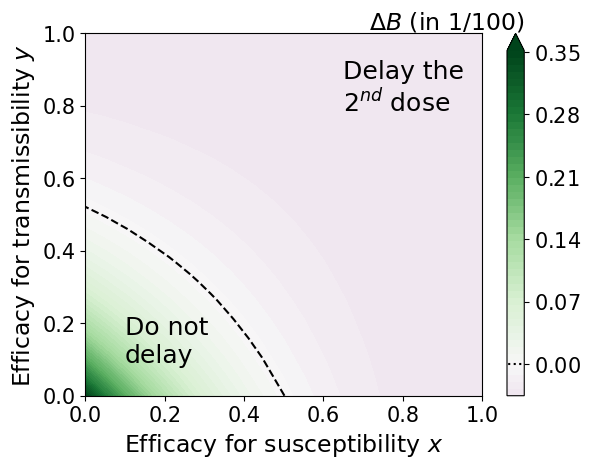

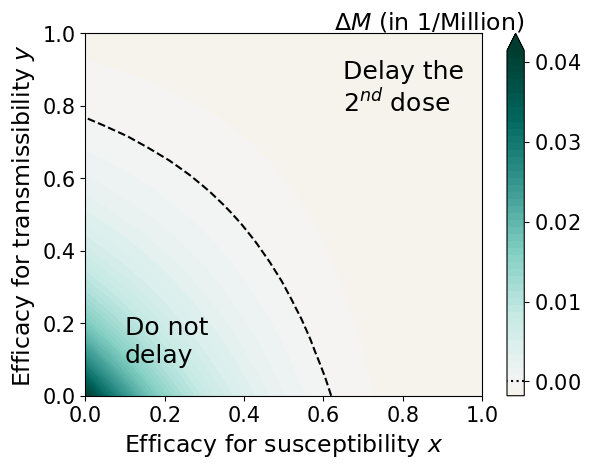

In [22]:
plot_heatmap_init()

## Figure S8

In [23]:
def plot_heatmap_init_I0(R0=R0D, gamma=gammaD, I0s=[9e-3, 5.1e-3, I0D],
                Rec0=Rec0D, l=lD, mu1=mu1D, mu_ratios=[0.1, 1, 10],
                folder="", name=""):
    if folder != "":
        folder = folder + "/"
    if name != "":
        name = "_" + name
        
    xStep = 20    #20
    xV = np.linspace(0, 1, xStep)
    yV = np.linspace(0, 1, xStep)
    XV, YV = np.meshgrid(xV, yV)
    wV = [20, 100]
    minW = min(wV)
    maxW = max(wV)  
    plt.rc('xtick', labelsize=tick_label_size)
    plt.rc('ytick', labelsize=tick_label_size)
    count_fig = 0
    
    I0_names = ["rki", "10_days", "5_days"]
    nb_param = len(I0s)
    
    for mu_ratio in mu_ratios:
        minWRecoveredV = np.zeros((nb_param, xStep, xStep))
        maxWRecoveredV = np.zeros((nb_param, xStep, xStep))
        minWMutV = np.zeros((nb_param, xStep, xStep))
        maxWMutV = np.zeros((nb_param, xStep, xStep))
        for n, I0 in enumerate(I0s):
            for i, y in enumerate(yV):
                for j, x in enumerate(xV):
                    minRecovered = sys.float_info.max
                    minMut = sys.float_info.max
                    # optWRecovered = wV[0]
                    # optWMut = wV[0]
                    for w in wV:
                        metrics = solve_and_plot(R0=R0, I0=I0, Rec0=Rec0, gamma=gamma, l=l, w=w,
                                                  x=x, y=y, mu1=mu1, mu_ratio=mu_ratio, isPlot=False)
                        if w == minW:
                            minWRecoveredV[n, i, j] = metrics[0]
                            minWMutV[n, i, j] = metrics[2] * 1e6
                        if w == maxW:
                            maxWRecoveredV[n, i, j] = metrics[0]
                            maxWMutV[n, i, j] = metrics[2] * 1e6


        # Differences
        diffRecoveredV = maxWRecoveredV - minWRecoveredV
        diffMutV = maxWMutV - minWMutV
        max_B = np.amax(np.array(diffRecoveredV))
        min_B = np.amin(np.array(diffRecoveredV))
        max_M = np.amax(np.array(diffMutV))
        min_M = np.amin(np.array(diffMutV))

        for n, I0 in enumerate(I0s):
            diff_name = ""
            if mu_ratio != mu_ratioD:
                diff_name = "_MuRatio" + str(('%f' % mu_ratio).rstrip('0').rstrip('.')).replace('.', '')
            diff_name = diff_name + "_" + I0_names[n]
            if mu_ratio == mu_ratioD:
                path = './Fig/' + folder + 'initial_conditions_I0/burden' + diff_name + name + '.pdf'
                plt.figure(count_fig)
                count_fig += 1
    #             ticks, is_transparent_tick = compute_diff_ticks(np.amin(np.array(diffRecoveredV)), vmax_B, 7)
                ticks, is_transparent_tick = compute_diff_ticks(min_B, max_B, 7)
    #             divnorm = colors.TwoSlopeNorm(vmin=-vmax_B, vcenter=0, vmax=vmax_B)
                divnorm = colors.TwoSlopeNorm(vmin=-max_B, vcenter=0, vmax=max_B)
    #             plt.contourf(XV, YV, diffRecoveredV[n], 20, norm=divnorm, cmap=cm.PRGn, extend='max')
                plt.contourf(XV, YV, diffRecoveredV[n], levels=np.linspace(min_B, max_B, 50), norm=divnorm, cmap=cm.PRGn, extend='max')
                bar = plt.colorbar(ticks=ticks)
                bar.ax.set_title('$\Delta B$ (in 1/100)', pad=0, loc='right', fontsize=fontsize)
                bar.ax.yaxis.set_major_formatter(FFormatter(fformat="%1.2f"))
                bar.ax.plot([-1, 1], [0, 0], 'k:')
                plt.contour(XV, YV, diffRecoveredV[n], 0, colors='k', linestyles='dashed')
                plt.xlabel(r"Efficacy for susceptibility $x$", fontsize=fontsize)
                plt.ylabel(r"Efficacy for transmissibility $y$", fontsize=fontsize)
#                 plt.text(0.95, -0.15, 'no effect', fontsize=tick_label_size, color='grey')
#                 plt.text(-0.27, 0.97, 'no\neffect', fontsize=tick_label_size, color='grey')
#                 plt.text(-0.25, -0.15, 'full effect', fontsize=tick_label_size, color='grey')
                plt.text(0.65, 0.85, 'Delay the\n$2^{nd}$ dose', fontsize=18, color='black', va='center')
                plt.text(0.1, 0.15, 'Do not\ndelay', fontsize=18, color='black', va='center')
                if is_transparent_tick:
                    bar.ax.yaxis.get_major_ticks()[0].tick2line.set_markersize(0)
                    bar.ax.get_yticklabels()[0].set_alpha(0)
                plt.savefig(path, bbox_inches='tight')
                print(path)

            path = './Fig/' + folder + 'initial_conditions_I0/mutants' + diff_name + name + '.pdf'
            plt.figure(count_fig)
            count_fig += 1
    #         ticks, is_transparent_tick = compute_diff_ticks(np.amin(np.array(diffMutV)), vmax_M, 7)
            ticks, is_transparent_tick = compute_diff_ticks(min_M, max_M, 7)
    #         divnorm = colors.TwoSlopeNorm(vmin=-vmax_M, vcenter=0, vmax=vmax_M)
            divnorm = colors.TwoSlopeNorm(vmin=-max_M, vcenter=0, vmax=max_M)
    #         plt.contourf(XV, YV, diffMutV[n], 20, norm=divnorm, cmap=cm.BrBG, extend='max')
            plt.contourf(XV, YV, diffMutV[n], levels=np.linspace(min_M, max_M, 50), norm=divnorm, cmap=cm.BrBG, extend='max')
            bar = plt.colorbar(ticks=ticks)
            bar.ax.set_title('$\Delta M$ (in 1/Million)', pad=0, loc='right', fontsize=fontsize)
            bar.ax.yaxis.set_major_formatter(FFormatter(fformat="%1.2f"))
            bar.ax.plot([-1, 1], [0, 0], 'k:')
            if not (mu_ratio == 0.1 and R0 == 2):
#             if name != "MuRatio01_R2":
                plt.contour(XV, YV, diffMutV[n], 0, colors='k', linestyles='dashed')
            plt.xlabel(r"Efficacy for susceptibility $x$", fontsize=fontsize)
            plt.ylabel(r"Efficacy for transmissibility $y$", fontsize=fontsize)
#             plt.text(0.95, -0.15, 'no effect', fontsize=tick_label_size, color='grey')
#             plt.text(-0.27, 0.97, 'no\neffect', fontsize=tick_label_size, color='grey')
#             plt.text(-0.25, -0.15, 'full effect', fontsize=tick_label_size, color='grey')
#             if mu_ratio <= 1 or (mu_ratio == 10 and R0 == R0D and l == lD):
            #if mu_ratio <= 1:
            plt.text(0.65, 0.85, 'Delay the\n$2^{nd}$ dose', fontsize=18, color='black', va='center')
            #if not (mu_ratio == 0.1 and (R0 != R0D or l != lD)):
            plt.text(0.1, 0.15, 'Do not\ndelay', fontsize=18, color='black', va='center')
            if is_transparent_tick:
                bar.ax.yaxis.get_major_ticks()[0].tick2line.set_markersize(0)
                bar.ax.get_yticklabels()[0].set_alpha(0)
            plt.savefig(path, bbox_inches='tight')
            print(path)

./Fig/initial_conditions_I0/mutants_MuRatio01_rki.pdf
./Fig/initial_conditions_I0/mutants_MuRatio01_10_days.pdf
./Fig/initial_conditions_I0/mutants_MuRatio01_5_days.pdf
./Fig/initial_conditions_I0/mutants_MuRatio1_rki.pdf
./Fig/initial_conditions_I0/mutants_MuRatio1_10_days.pdf
./Fig/initial_conditions_I0/mutants_MuRatio1_5_days.pdf
./Fig/initial_conditions_I0/burden_rki.pdf
./Fig/initial_conditions_I0/mutants_rki.pdf
./Fig/initial_conditions_I0/burden_10_days.pdf
./Fig/initial_conditions_I0/mutants_10_days.pdf
./Fig/initial_conditions_I0/burden_5_days.pdf
./Fig/initial_conditions_I0/mutants_5_days.pdf


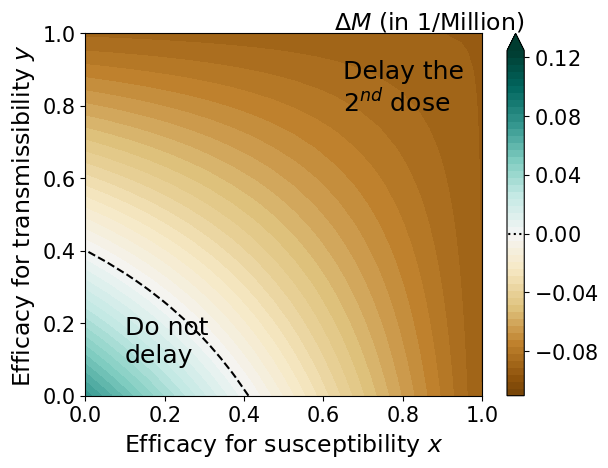

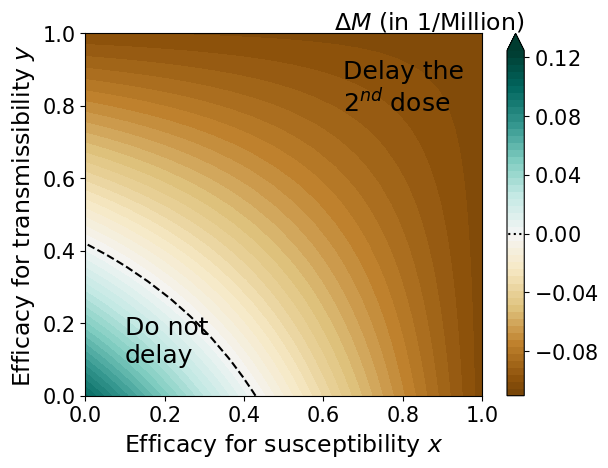

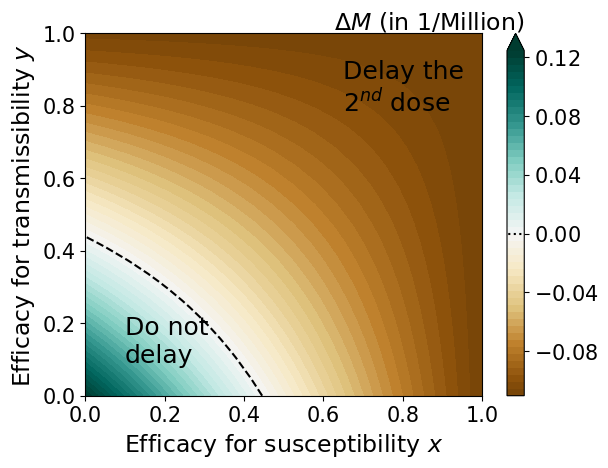

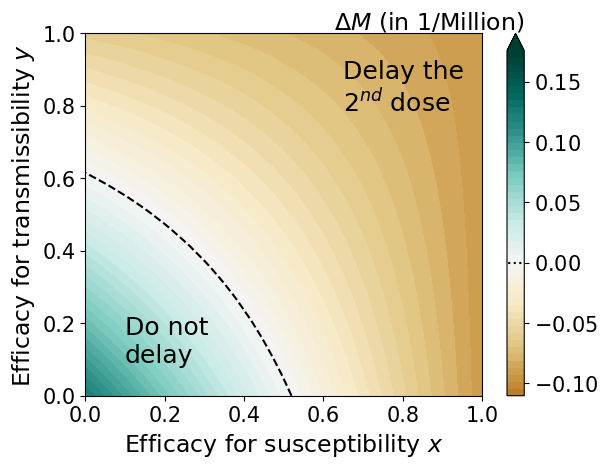

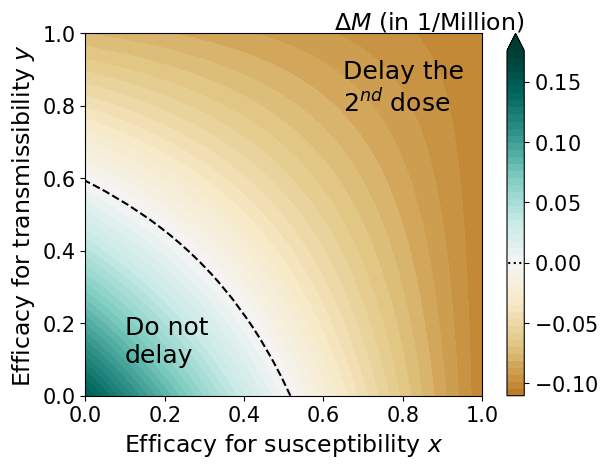

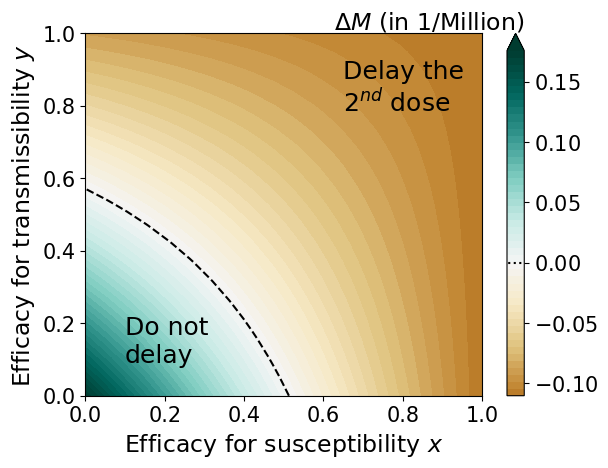

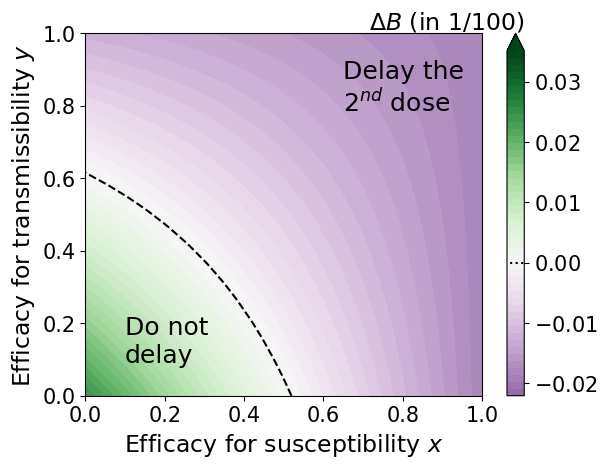

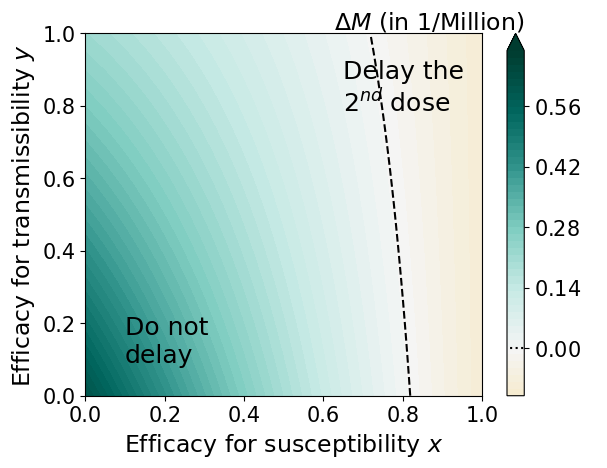

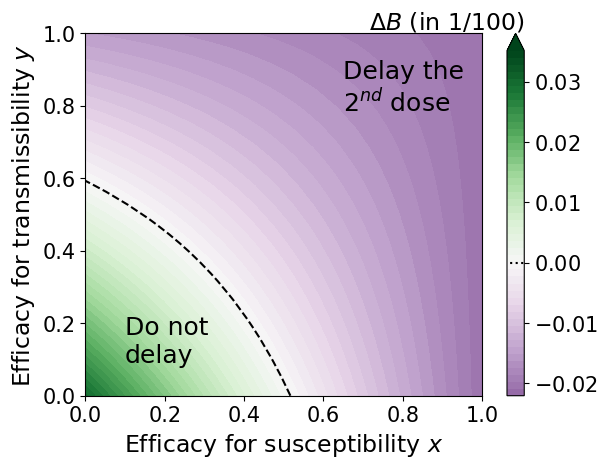

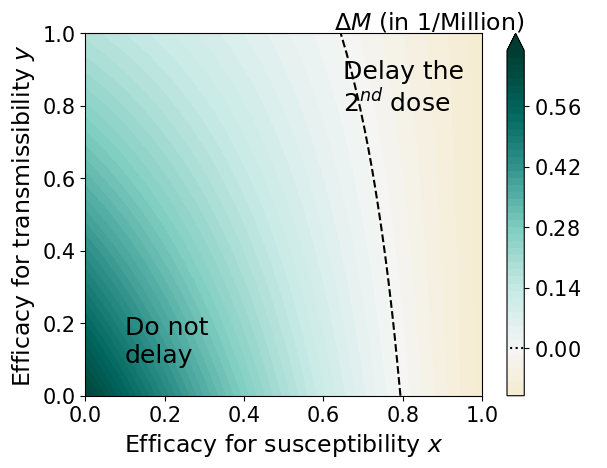

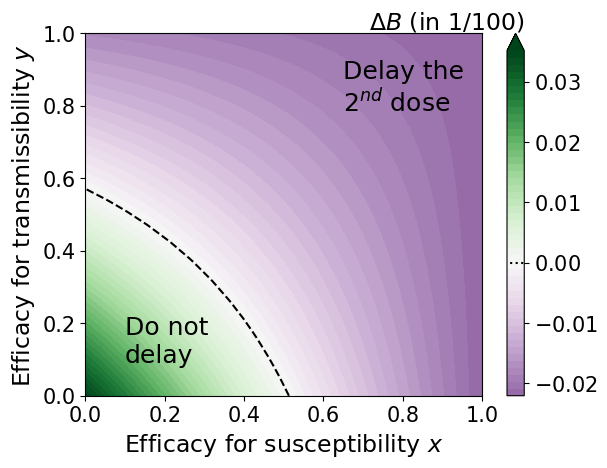

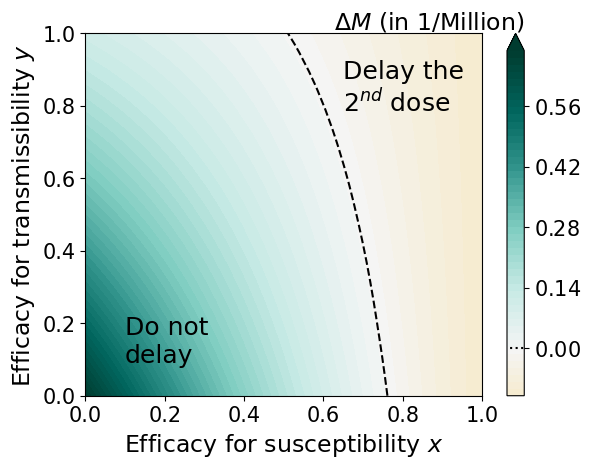

In [24]:
plot_heatmap_init_I0()

## Severity for half-vaccinated. Figure S4

In [25]:
def plot_heatmap_severity(R0=R0D, gamma=gammaD, I0=I0D, Rec0=Rec0D, l=lD, mu1=mu1D,
                 mu_ratio=mu_ratioD, z_list=[0, 0.5, 1], folder="", name=""):
    if folder != "":
        folder = folder + "/"
    if name != "":
        name = "_" + name
        
    xStep = 20    #20
    xV = np.linspace(0, 1, xStep)
    yV = np.linspace(0, 1, xStep)
    XV, YV = np.meshgrid(xV, yV)
    wV = [20, 100]
    minW = min(wV)
    maxW = max(wV)  
    plt.rc('xtick', labelsize=tick_label_size)
    plt.rc('ytick', labelsize=tick_label_size)
    count_fig = 0
    
    nb_param = len(z_list)
    
    minWRecoveredV = np.zeros((nb_param, xStep, xStep))
    maxWRecoveredV = np.zeros((nb_param, xStep, xStep))
    for n, z in enumerate(z_list):
        for i, y in enumerate(yV):
            for j, x in enumerate(xV):
                minRecovered = sys.float_info.max
                minMut = sys.float_info.max
                # optWRecovered = wV[0]
                # optWMut = wV[0]
                for w in wV:
                    metrics = solve_and_plot(R0=R0, I0=I0, Rec0=Rec0, gamma=gamma, l=l, w=w,
                                              x=x, y=y, mu1=mu1, mu_ratio=mu_ratio, isPlot=False)
                    if w == minW:
                        minWRecoveredV[n, i, j] = (metrics[4] +
                                                   (1 - z) * metrics[1]) * 100
                    if w == maxW:
                        maxWRecoveredV[n, i, j] = (metrics[4] +
                                                   (1 - z) * metrics[1]) * 100


#     # Absolute_values of B and M
#     vmax = max(np.amax(np.array(maxWRecoveredV)), np.amax(np.array(minWRecoveredV)))
#     vmin = min(np.amin(np.array(maxWRecoveredV)), np.amin(np.array(minWRecoveredV)))
#     for n, z in enumerate(z_list):
#         data = [maxWRecoveredV[n], minWRecoveredV[n]]
#         abs_name = "_z" + str(('%f' % z).rstrip('0').rstrip('.')).replace('.', '')
#         for i, d in enumerate(data):
#             path = './Fig/severity/' + folder + 'absolute/burden_Omega' + str(wV[i]) + abs_name + name + '.pdf'
#             cmap = cm.viridis

#             plt.figure(count_fig)
#             count_fig += 1
#             levels = np.linspace(vmin, vmax, 20)
#             ticks = np.linspace(vmin, vmax, 6)
#             plt.pcolormesh(XV, YV, d, shading='gouraud', cmap=cmap, vmin=vmin, vmax=vmax)
#             bar = plt.colorbar(ticks=ticks, extend='both', shrink=0.92)
#             bar.ax.set_title('$B$', pad=28, loc='right', fontsize=fontsize)
#             pos1 = bar.ax.get_position()
#             bar.ax.set_position([pos1.x0, pos1.y0 - 0.035, pos1.width, pos1.height])
#             bar.ax.yaxis.set_major_formatter(FFormatter(fformat="%1.2f"))
#             bar.ax.yaxis.get_offset_text().set_position((3.5, 0))
#             plt.xlabel(r"Efficacy for susceptibility $x$", fontsize=fontsize)
#             plt.ylabel(r"Efficacy for transmissibility $y$", fontsize=fontsize)
# #             plt.text(0.95, -0.15, 'no effect', fontsize=tick_label_size, color='grey')
# #             plt.text(-0.27, 0.97, 'no\neffect', fontsize=tick_label_size, color='grey')
# #             plt.text(-0.25, -0.15, 'full effect', fontsize=tick_label_size, color='grey')
#             plt.savefig(path, bbox_inches='tight')
#             print(path)


    # Differences
    diffRecoveredV = maxWRecoveredV - minWRecoveredV
    max_B = np.amax(np.array(diffRecoveredV))
    min_B = np.amin(np.array(diffRecoveredV))

    for n, z in enumerate(z_list):
        diff_name = "_z" + str(('%f' % z).rstrip('0').rstrip('.')).replace('.', '')
        path = './Fig/severity/' + folder + 'burden' + diff_name + name + '.pdf'
        plt.figure(count_fig)
        count_fig += 1
#             ticks, is_transparent_tick = compute_diff_ticks(np.amin(np.array(diffRecoveredV)), vmax_B, 7)
        ticks, is_transparent_tick = compute_diff_ticks(min_B, max_B, 7)
#             divnorm = colors.TwoSlopeNorm(vmin=-vmax_B, vcenter=0, vmax=vmax_B)
        divnorm = colors.TwoSlopeNorm(vmin=-max_B, vcenter=0, vmax=max_B)
#             plt.contourf(XV, YV, diffRecoveredV[n], 20, norm=divnorm, cmap=cm.PRGn, extend='max')
        plt.contourf(XV, YV, diffRecoveredV[n], levels=np.linspace(min_B, max_B, 50), norm=divnorm, cmap=cm.PRGn, extend='max')
        bar = plt.colorbar(ticks=ticks)
        bar.ax.set_title('$\Delta B$ (in 1/100)', pad=0, loc='right', fontsize=fontsize)
        bar.ax.yaxis.set_major_formatter(FFormatter(fformat="%1.2f"))
        bar.ax.plot([-1, 1], [0, 0], 'k:')
        plt.contour(XV, YV, diffRecoveredV[n], 0, colors='k', linestyles='dashed')
        plt.xlabel(r"Efficacy for susceptibility $x$", fontsize=fontsize)
        plt.ylabel(r"Efficacy for transmissibility $y$", fontsize=fontsize)
        plt.text(0.65, 0.85, 'Delay the\n$2^{nd}$ dose', fontsize=18, color='black', va='center')
        plt.text(0.1, 0.15, 'Do not\ndelay', fontsize=18, color='black', va='center')
#         plt.text(0.95, -0.15, 'no effect', fontsize=tick_label_size, color='grey')
#         plt.text(-0.27, 0.97, 'no\neffect', fontsize=tick_label_size, color='grey')
#         plt.text(-0.25, -0.15, 'full effect', fontsize=tick_label_size, color='grey')
        if is_transparent_tick:
            bar.ax.yaxis.get_major_ticks()[0].tick2line.set_markersize(0)
            bar.ax.get_yticklabels()[0].set_alpha(0)
        plt.savefig(path, bbox_inches='tight')
        print(path)

./Fig/severity/burden_z0.pdf
./Fig/severity/burden_z05.pdf
./Fig/severity/burden_z1.pdf


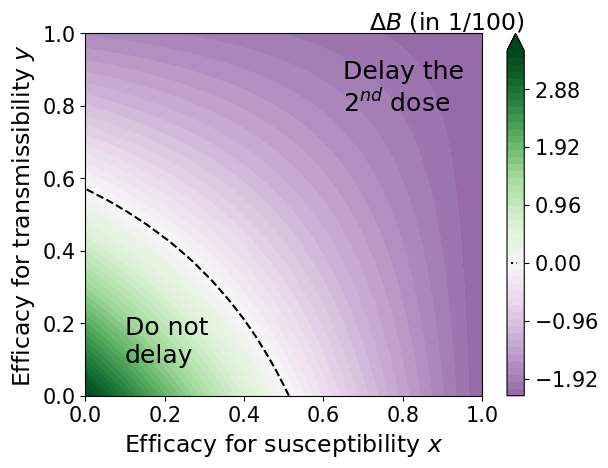

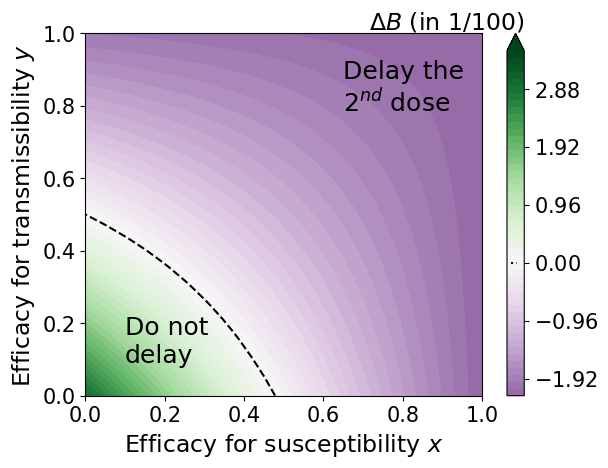

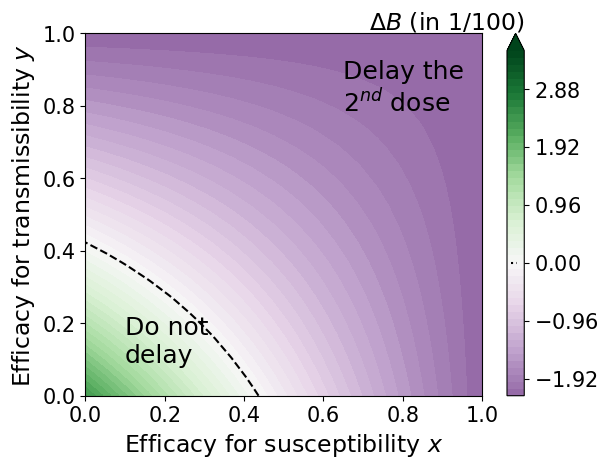

In [26]:
plot_heatmap_severity()

## Mutant transmission. Figures S5-7

In [27]:
def solve_and_plot_transmission(R0=R0D, gamma=gammaD, I0=I0D, Rec0=Rec0D, mu1=mu1D, mu_ratio=mu_ratioD, l=lD, w=wD,
                                x=xD, y=yD, yM=yD, tmax_plot=300, log_scale=False,
                                file_name="dynamics_default"):
    beta = R0 * gamma
    tau = 1 / w
    mu2 = mu1 * mu_ratio
    x0 = [(1 - I0 - Rec0) * N, 0, 0, I0 * N, 0, Rec0 * N]
    res = solve_ivp(model, [0, tmax], x0, t_eval=tV, rtol=relativeTolerance, atol=absoluteTolerance,
                    args=(beta, gamma, l, tau, x, y))
    if not res.success:
        print(res.message)
    sol = res.y
            
    rec = simps(gamma * sol[3] + gamma * sol[4], x=res.t)
    recVacc = simps(gamma * sol[4], x=res.t)
    mut = simps(mu1 * sol[3] + mu2 * sol[4], x=res.t)
    mutVacc = simps(mu2 * sol[4], x=res.t)
    recS = simps(gamma * sol[3], x=res.t)
    mutS = simps(mu1 * sol[3], x=res.t)
    mutTrans = simps(mu1 * sol[3] + (1 - yM) * mu2 * sol[4], x=res.t)
    return rec, recVacc, mut, mutVacc, recS, mutS, mutTrans

In [28]:
def transmissiblity_mutant(y, yM_param, yM_type):
    if yM_type == "Independent":
        return yM_param
    else:
        return  yM_param * y

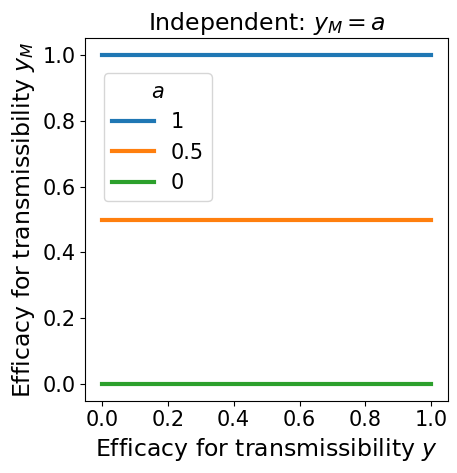

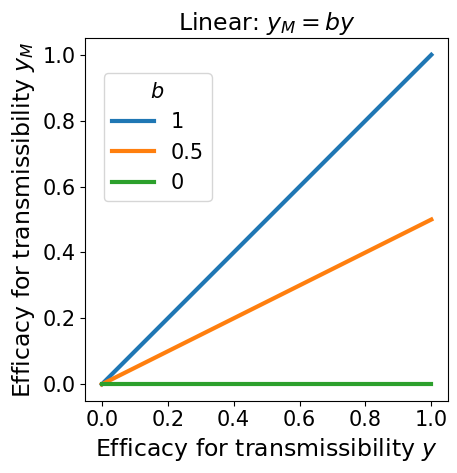

In [29]:
yStep = 500
yV = np.linspace(0, 1, yStep)
plt.rc('xtick', labelsize=tick_label_size)
plt.rc('ytick', labelsize=tick_label_size)
titles = ["Independent: $y_M=a$", "Linear: $y_M=b y$"]
legend_titles = ["$a$", "$b$"]
for i, yM_type in enumerate(["Independent", "Linear"]):
    plt.figure(i)
    yM_param_list = [1, 0.5, 0]
    for j, yM_param in enumerate(yM_param_list):
        yMV = np.empty(yStep)
        for k, y in enumerate(yV):
            yMV[k] = transmissiblity_mutant(y, yM_param, yM_type)
        plt.plot(yV, yMV, label=yM_param, linewidth=3)
    plt.xlabel(r"Efficacy for transmissibility $y$", fontsize=fontsize)
    plt.ylabel(r"Efficacy for transmissibility $y_M$", fontsize=fontsize)
#     plt.text(1.1, -0.15, 'no\neffect', fontsize=tick_label_size, color='grey')
#     plt.text(-0.3, 1.05, 'no\neffect', fontsize=tick_label_size, color='grey')
#     plt.text(-0.22, -0.18, 'full\neffect', fontsize=tick_label_size, color='grey')
    plt.title(titles[i], fontsize=fontsize)
    legend = plt.legend(title = legend_titles[i], fontsize=fontsize_legend, loc=(0.05, 0.55), frameon=True)
    legend.get_title().set_fontsize(fontsize_legend)
    plt.xticks(np.arange(0, 1.2, 0.2))
    plt.yticks(np.arange(0, 1.2, 0.2))
    plt.gca().set_aspect(1)
    plt.savefig('./Fig/mutant_transmission/relationship/' + yM_type + '.pdf', bbox_inches='tight')

In [30]:
def plot_heatmap_transmission(R0=R0D, gamma=gammaD, I0=I0D, Rec0=Rec0D, l=lD, mu1=mu1D,
                 mu_ratios=[0.1, 1, 10], yM_param_list=[0, 0.5, 1], yM_type="Independent", folder="", name=""):
    if folder != "":
        folder = folder + "/"
    if name != "":
        name = "_" + name
        
    xStep = 20    #20
    xV = np.linspace(0, 1, xStep)
    yV = np.linspace(0, 1, xStep)
    XV, YV = np.meshgrid(xV, yV)
    wV = [20, 100]
    minW = min(wV)
    maxW = max(wV)  
    plt.rc('xtick', labelsize=tick_label_size)
    plt.rc('ytick', labelsize=tick_label_size)
    count_fig = 0
    
    nb_param = len(yM_param_list)
    
    for mu_ratio in mu_ratios:
        minWRecoveredV = np.zeros((nb_param, xStep, xStep))
        maxWRecoveredV = np.zeros((nb_param, xStep, xStep))
        minWMutV = np.zeros((nb_param, xStep, xStep))
        maxWMutV = np.zeros((nb_param, xStep, xStep))
        for n, yM_param in enumerate(yM_param_list):
            for i, y in enumerate(yV):
                yM = transmissiblity_mutant(y, yM_param, yM_type)
                for j, x in enumerate(xV):
                    minRecovered = sys.float_info.max
                    minMut = sys.float_info.max
                    # optWRecovered = wV[0]
                    # optWMut = wV[0]
                    for w in wV:
                        metrics = solve_and_plot_transmission(R0=R0, I0=I0, Rec0=Rec0, gamma=gamma, l=l, w=w,
                                                  x=x, y=y, yM=yM, mu1=mu1, mu_ratio=mu_ratio)
                        if w == minW:
                            minWRecoveredV[n, i, j] = metrics[0]
                            minWMutV[n, i, j] = metrics[6] * 1e6
                        if w == maxW:
                            maxWRecoveredV[n, i, j] = metrics[0]
                            maxWMutV[n, i, j] = metrics[6] * 1e6


#         if mu_ratio == mu_ratioD:
#             # Absolute_values of M
#             vmax = max(np.amax(np.array(maxWMutV)), np.amax(np.array(minWMutV)))
#             vmin = min(np.amin(np.array(maxWMutV)), np.amin(np.array(minWMutV)))
#             for n, yM_param in enumerate(yM_param_list):
#                 data = [maxWMutV[n], minWMutV[n]]
#                 abs_name = "_" + yM_type + "_a" + str(('%f' % yM_param).rstrip('0').rstrip('.')).replace('.', '')
#                 for i, d in enumerate(data):
#                     path = './Fig/mutant_transmission/' + folder + 'absolute/mutants_Omega' + str(wV[i-2]) + abs_name + name + '.pdf'
#                     cmap = cm.plasma

#                     plt.figure(count_fig)
#                     count_fig += 1
#                     levels = np.linspace(vmin, vmax, 20)
#                     ticks = np.linspace(vmin, vmax, 6)
#                     plt.pcolormesh(XV, YV, d, shading='gouraud', cmap=cmap, vmin=vmin, vmax=vmax)
#                     bar = plt.colorbar(ticks=ticks, extend='both', shrink=0.92)
#                     bar.ax.set_title('$M_o$ (in 1/Million)', pad=28, loc='right', fontsize=fontsize)
#                     pos1 = bar.ax.get_position()
#                     bar.ax.set_position([pos1.x0, pos1.y0 - 0.035, pos1.width, pos1.height])
#                     bar.ax.yaxis.set_major_formatter(FFormatter(fformat="%1.2f"))
#                     bar.ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
#                     bar.ax.yaxis.get_offset_text().set_position((3.5, 0))
#                     plt.xlabel(r"Efficacy for susceptibility $x$", fontsize=fontsize)
#                     plt.ylabel(r"Efficacy for transmissibility $y$", fontsize=fontsize)
# #                     plt.text(0.95, -0.15, 'no effect', fontsize=tick_label_size, color='grey')
# #                     plt.text(-0.27, 0.97, 'no\neffect', fontsize=tick_label_size, color='grey')
# #                     plt.text(-0.25, -0.15, 'full effect', fontsize=tick_label_size, color='grey')
#                     plt.savefig(path, bbox_inches='tight')
#                     print(path)


        # Differences
        diffMutV = maxWMutV - minWMutV
        max_M = np.amax(np.array(diffMutV))
        min_M = np.amin(np.array(diffMutV))

        for n, yM_param in enumerate(yM_param_list):
            diff_name = ""
            if mu_ratio != mu_ratioD:
                diff_name = "_MuRatio" + str(('%f' % mu_ratio).rstrip('0').rstrip('.')).replace('.', '')
            diff_name = diff_name + "_" + yM_type + "_a" + str(('%f' % yM_param).rstrip('0').rstrip('.')).replace('.', '')
            path = './Fig/mutant_transmission/' + folder + 'diff/mutants' + diff_name + name + '.pdf'
            plt.figure(count_fig)
            count_fig += 1
    #         ticks, is_transparent_tick = compute_diff_ticks(np.amin(np.array(diffMutV)), vmax_M, 7)
            ticks, is_transparent_tick = compute_diff_ticks(min_M, max_M, 7)
    #         divnorm = colors.TwoSlopeNorm(vmin=-vmax_M, vcenter=0, vmax=vmax_M)
            divnorm = colors.TwoSlopeNorm(vmin=-max_M, vcenter=0, vmax=max_M)
    #         plt.contourf(XV, YV, diffMutV[n], 20, norm=divnorm, cmap=cm.BrBG, extend='max')
            plt.contourf(XV, YV, diffMutV[n], levels=np.linspace(min_M, max_M, 50), norm=divnorm, cmap=cm.BrBG, extend='max')
            bar = plt.colorbar(ticks=ticks)
            bar.ax.set_title('$\Delta M_o$ (in 1/Million)', pad=0, loc='right', fontsize=fontsize)
            bar.ax.yaxis.set_major_formatter(FFormatter(fformat="%1.2f"))
            bar.ax.plot([-1, 1], [0, 0], 'k:')
            if not (mu_ratio == 0.1 and R0 == 2):
#             if name != "MuRatio01_R2":
                plt.contour(XV, YV, diffMutV[n], 0, colors='k', linestyles='dashed')
            plt.xlabel(r"Efficacy for susceptibility $x$", fontsize=fontsize)
            plt.ylabel(r"Efficacy for transmissibility $y$", fontsize=fontsize)
#             plt.text(0.95, -0.15, 'no effect', fontsize=tick_label_size, color='grey')
#             plt.text(-0.27, 0.97, 'no\neffect', fontsize=tick_label_size, color='grey')
#             plt.text(-0.25, -0.15, 'full effect', fontsize=tick_label_size, color='grey')
#             if mu_ratio <= 1 or (mu_ratio == 10 and R0 == R0D and l == lD):
#             if mu_ratio <= 1 or (mu_ratio == 10 and yM_param <= 0.5):
            plt.text(0.65, 0.85, 'Delay the\n$2^{nd}$ dose', fontsize=18, color='black', va='center')
#             if not (mu_ratio == 0.1 and (R0 != R0D or l != lD)):
            plt.text(0.1, 0.15, 'Do not\ndelay', fontsize=18, color='black', va='center')
            if is_transparent_tick:
                bar.ax.yaxis.get_major_ticks()[0].tick2line.set_markersize(0)
                bar.ax.get_yticklabels()[0].set_alpha(0)
            plt.savefig(path, bbox_inches='tight')
            print(path)

./Fig/mutant_transmission/diff/mutants_MuRatio01_Independent_a0.pdf
./Fig/mutant_transmission/diff/mutants_MuRatio01_Independent_a05.pdf
./Fig/mutant_transmission/diff/mutants_MuRatio01_Independent_a1.pdf
./Fig/mutant_transmission/diff/mutants_MuRatio1_Independent_a0.pdf
./Fig/mutant_transmission/diff/mutants_MuRatio1_Independent_a05.pdf
./Fig/mutant_transmission/diff/mutants_MuRatio1_Independent_a1.pdf
./Fig/mutant_transmission/diff/mutants_Independent_a0.pdf
./Fig/mutant_transmission/diff/mutants_Independent_a05.pdf
./Fig/mutant_transmission/diff/mutants_Independent_a1.pdf


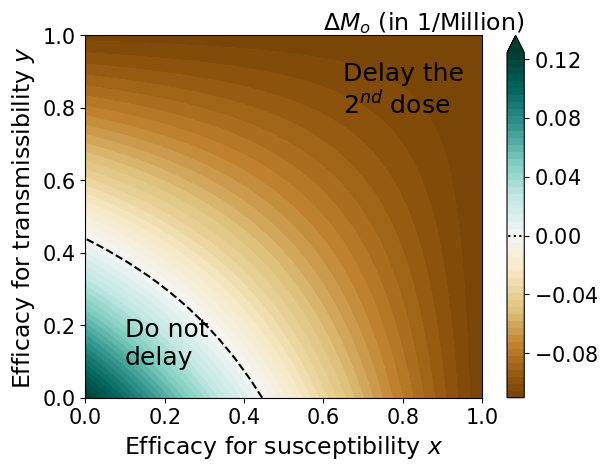

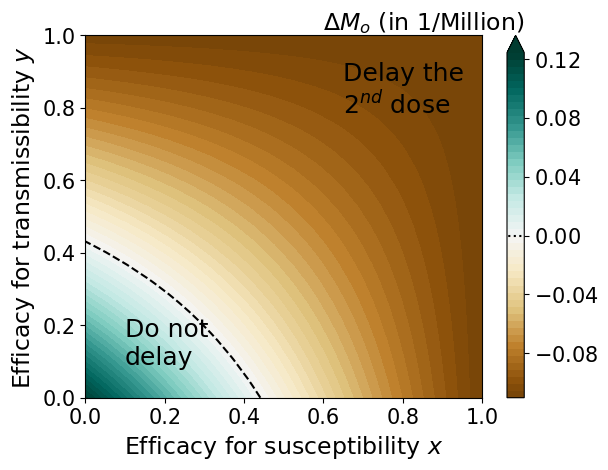

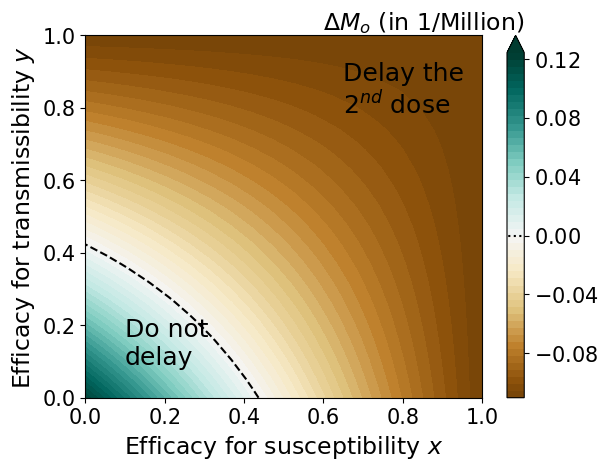

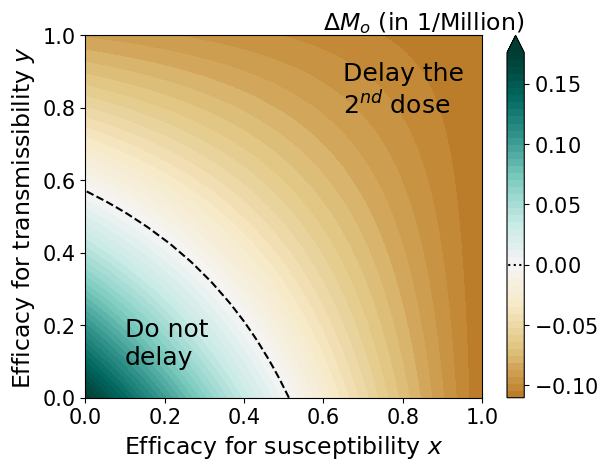

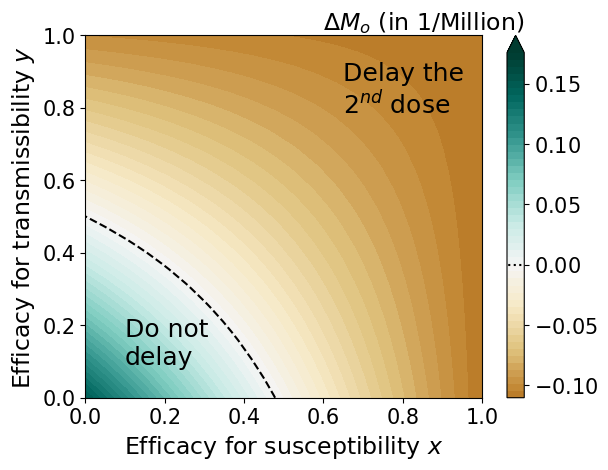

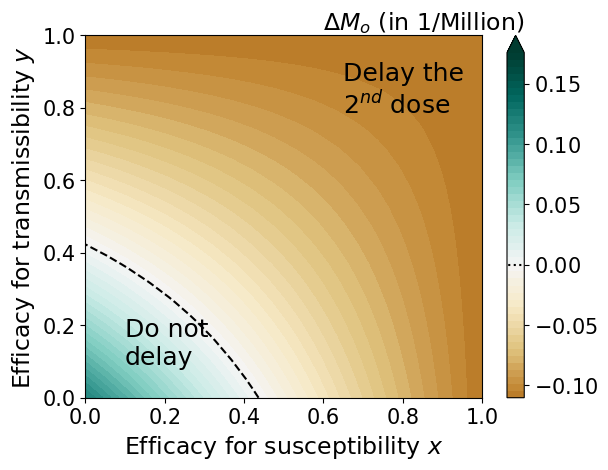

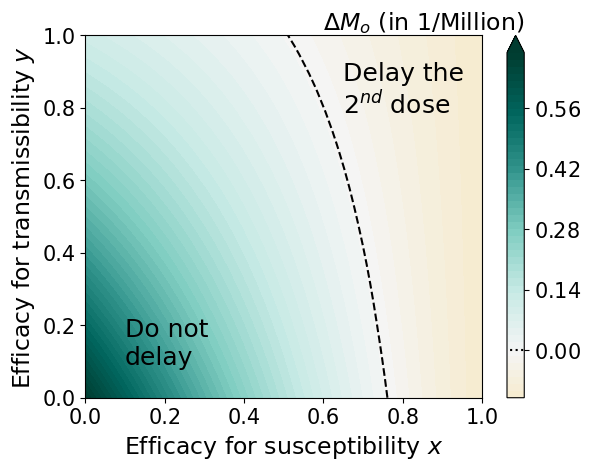

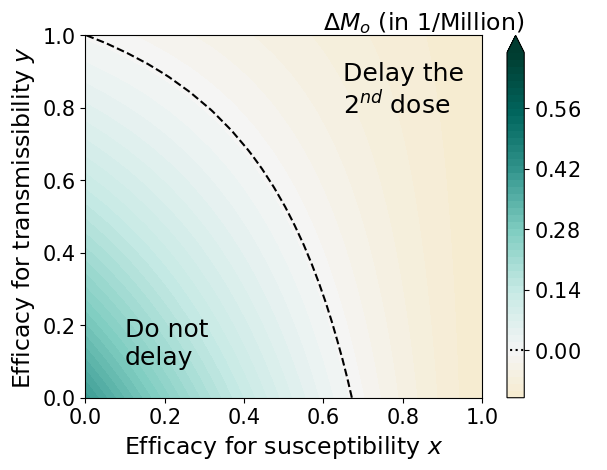

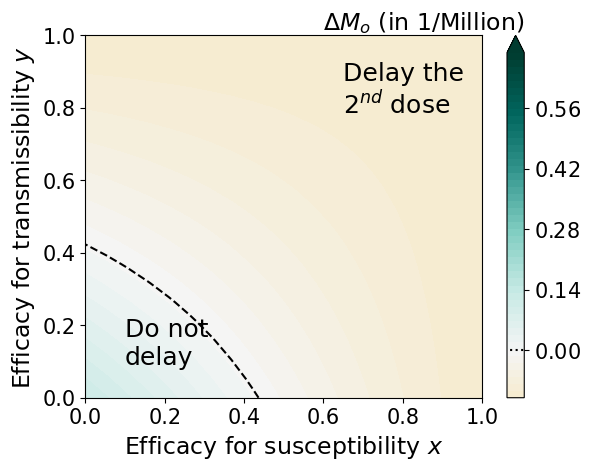

In [31]:
plot_heatmap_transmission()

./Fig/mutant_transmission/diff/mutants_MuRatio01_Linear_a0.pdf
./Fig/mutant_transmission/diff/mutants_MuRatio01_Linear_a05.pdf
./Fig/mutant_transmission/diff/mutants_MuRatio01_Linear_a1.pdf
./Fig/mutant_transmission/diff/mutants_MuRatio1_Linear_a0.pdf
./Fig/mutant_transmission/diff/mutants_MuRatio1_Linear_a05.pdf
./Fig/mutant_transmission/diff/mutants_MuRatio1_Linear_a1.pdf
./Fig/mutant_transmission/diff/mutants_Linear_a0.pdf
./Fig/mutant_transmission/diff/mutants_Linear_a05.pdf
./Fig/mutant_transmission/diff/mutants_Linear_a1.pdf


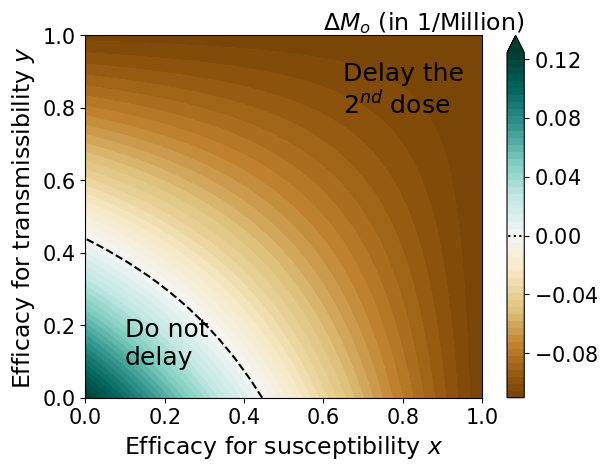

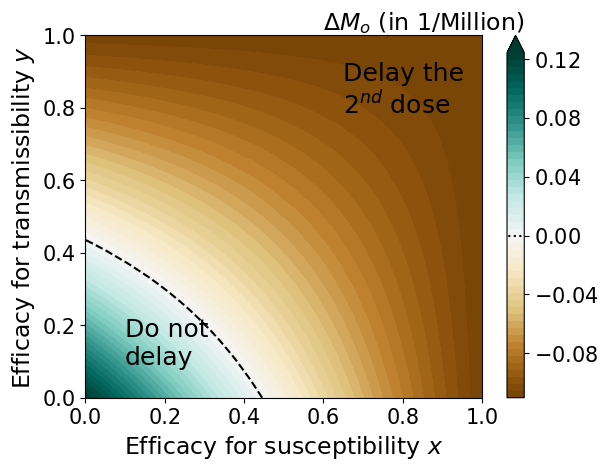

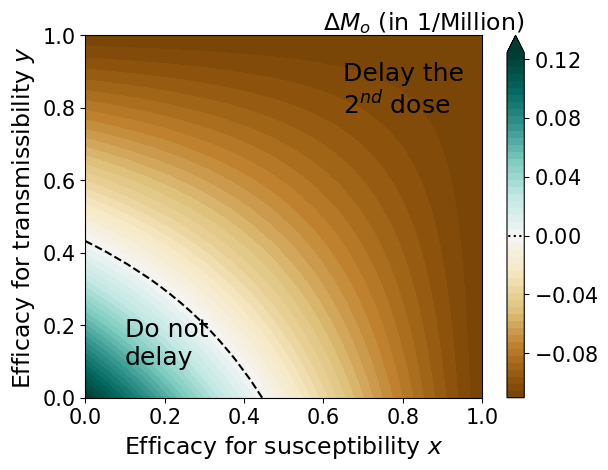

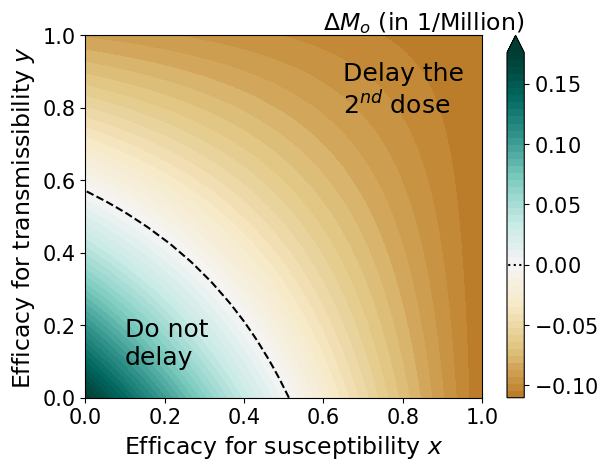

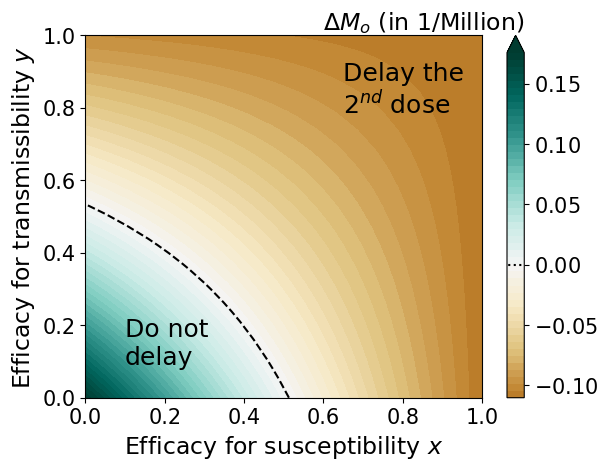

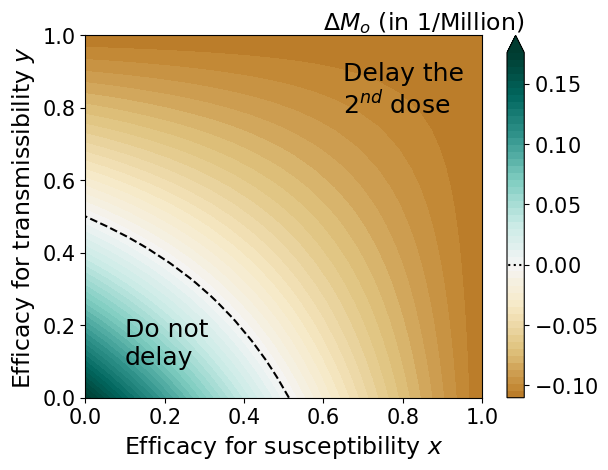

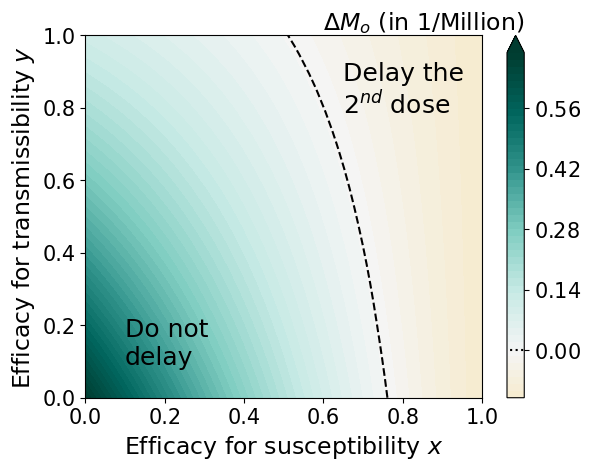

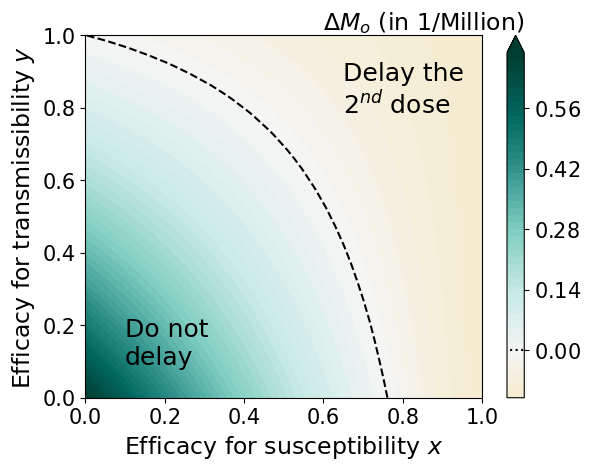

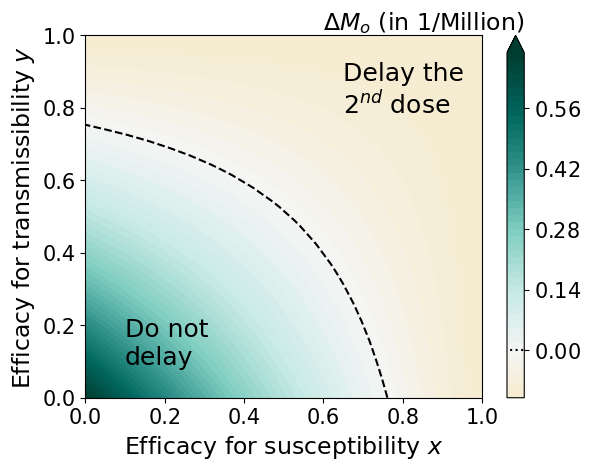

In [32]:
plot_heatmap_transmission(yM_type="Linear")

## SEIR. Figures S1-3

In [33]:
sigmaD = 1/6

def model_SEIR(t, xV, beta, sigma, gamma, l, tau, x, y):
    S = xV[0]
    VH = xV[1]
    VF = xV[2]
    E = xV[3]
    VE = xV[4]
    I = xV[5]
    VI = xV[6]
    R = xV[7]
    if S < 0:
        #S = 0
        dSdt = 0
    else:
        dSdt = - (l - tau * VH)
    dSdt -= beta * S * (I + (1 - y) * VI) / N
    if S < 0:
        if VH < 0:
            #VH = 0
            dVHdt = 0
        else:
            dVHdt = - min(l, tau_max * VH)
    else:
        dVHdt = l - 2 * tau * VH
    dVHdt -= (1 - x) * beta * VH * (I + (1 - y) * VI) / N
    if S < 0:
        if VH < 0:
            dVFdt = 0
        else:
            dVFdt = min(l, tau_max * VH)
    else:
        dVFdt = tau * VH
    dEdt = (beta * S * (I + (1 - y) * VI) / N) - sigma * E
    dVEdt = ((1 - x) * beta * VH * (I + (1 - y) * VI) / N) - sigma * VE
    dIdt = sigma * E - gamma * I
    dVIdt = sigma * VE - gamma * VI
    dRdt = gamma * I + gamma * VI
    syst = [dSdt, dVHdt, dVFdt, dEdt, dVEdt, dIdt, dVIdt, dRdt]
    return syst

In [34]:
def solve_and_plot_SEIR(R0=R0D, sigma=sigmaD, gamma=gammaD, I0=I0D, Rec0=Rec0D, mu1=mu1D, mu_ratio=mu_ratioD, l=lD,
                        w=wD, x=xD, y=yD, isPlot=True, tmax_plot=300, log_scale=False, file_name="dynamics_default"):
    beta = R0 * gamma
    tau = 1 / w
    mu2 = mu1 * mu_ratio
    x0 = [(1 - (2 * I0) - Rec0) * N, 0, 0, I0 * N, 0, I0 * N, 0, Rec0 * N]
    res = solve_ivp(model_SEIR, [0, tmax], x0, t_eval=tV, rtol=relativeTolerance, atol=absoluteTolerance,
                    args=(beta, sigma, gamma, l, tau, x, y))
    if not res.success:
        print(res.message)
    sol = res.y

    if isPlot:
        labels=['S', '$V_H$', '$V_F$', '$E$', '$V_{H,E}$', '$I$', '$V_{H,I}$', 'R']
        
        
        plt.rc('xtick', labelsize=tick_label_size)
        plt.rc('ytick', labelsize=tick_label_size)
        color_map = ['#006ddb', '#6db6ff', '#b6dbff', '#490092', '#b66dff', '#ff6db6', '#ffb6db', '#db6d00']
#         color_map = ['#b6dbff', '#6db6ff', '#006ddb', '#b66dff', '#490092', '#ffb6db', '#ff6db6', '#db6d00']
        line_styles = ['-', '--', ':', '-', '--', '-', '--', '-']
#         line_styles = [':', '--', '-', ':', '-', ':', '-', ':']
        if l > 0:
            indices = range(8)
        else:
            indices = [0, 3, 5, 7]
        for i in indices:
            plt.plot(res.t[:tmax_plot], sol[i][:tmax_plot], label=labels[i], linewidth=3, color=color_map[i], linestyle=line_styles[i])
        plt.ylabel('Fraction', fontsize=fontsize)
        plt.xlabel('Days since start of vaccine roll-out', fontsize=fontsize)
#         plt.legend(fontsize=fontsize, bbox_to_anchor=(1.0, 1.0), loc='upper left', ncol=1)
        x_text_VH = res.t[np.argmax(sol[1,:tmax_plot])]
        y_text_VH = np.max(sol[1,:tmax_plot])
        if l > 0:
            if w == 20:
                x_text_VH -= 150
                y_text_VH += 0.03
                text_VH = "Few half-vaccinated"
            elif  w == 100:
                x_text_VH -= 600
                y_text_VH -= 0.06
                text_VH = "Many half-vaccinated"
            plt.text(x_text_VH, y_text_VH, text_VH, color='#6db6ff', fontsize=15)
        x_text_R = tmax_plot
        y_text_R = np.max(sol[-1,:tmax_plot]) + 0.03
        text_R = "$R(\infty)=$" + str("%0.2f" % sol[-1][-1])
        plt.text(x_text_R, y_text_R, text_R, color='#db6d00', fontsize=15, ha='right')
        if log_scale:
            plt.yscale('log')
            plt.ylim(1e-5, 2)
        plt.savefig('./Fig/SEIR/dynamics/' + file_name + '.pdf', bbox_inches='tight')
            
    rec = simps(gamma * sol[5] + gamma * sol[6], x=res.t)
    recVacc = simps(gamma * sol[6], x=res.t)
    mut = simps(mu1 * sol[5] + mu2 * sol[6], x=res.t)
    mutVacc = simps(mu2 * sol[6], x=res.t)
    recS = simps(gamma * sol[5], x=res.t)
    mutS = simps(mu1 * sol[5], x=res.t)
    return rec, recVacc, mut, mutVacc, recS, mutS

### Plot a single trajectory

In [35]:
def dynamics_SEIR(R0=R0D, sigma=sigmaD, gamma=gammaD, I0=I0D, Rec0=Rec0D, l=lD, w=wD, x=xD, y=yD,
             log_scale=False, tmax_plot=300, file_name="dynamics_default"):
    tau = 1 / w
    metrics = solve_and_plot_SEIR(R0=R0, I0=I0, Rec0=Rec0, gamma=gamma, l=l, w=w, x=x, y=y,
                             log_scale=log_scale, tmax_plot=tmax_plot, file_name=file_name)
    
    print("Total burden: %.2e \nTotal number of mutants: %.2e" % (metrics[0], metrics[2]))

Total burden: 1.05e-01 
Total number of mutants: 5.23e-07


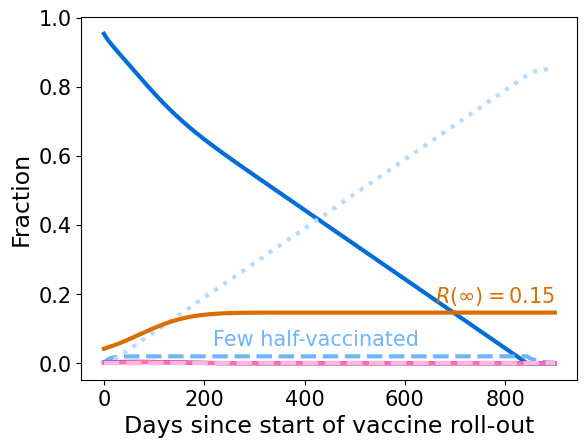

In [36]:
dynamics_SEIR(log_scale=False, tmax_plot=900, file_name="dynamics",
             x=1, y=1)

Total burden: 8.76e-02 
Total number of mutants: 4.38e-07


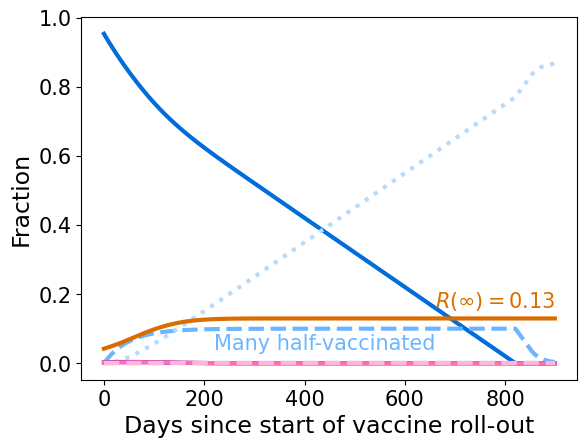

In [37]:
dynamics_SEIR(log_scale=False, w=100, tmax_plot=900, file_name="dynamics_Omega100",
             x=1, y=1)

Total burden: 2.62e-01 
Total number of mutants: 1.31e-06


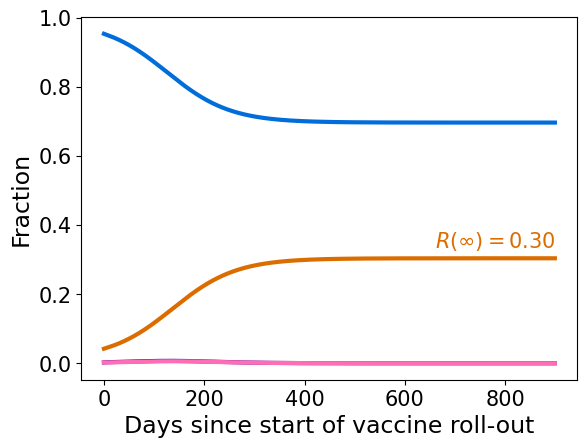

In [38]:
dynamics_SEIR(log_scale=False, l=0, tmax_plot=900, file_name="dynamics_no_vaccine",
             x=1, y=1)

Generate legend

In [39]:
import pylab
labels=['S', '$V_H$', '$V_F$', '$E$', '$V_{H,E}$', '$I$', '$V_{H,I}$', 'R']
color_map = ['#006ddb', '#6db6ff', '#b6dbff', '#490092', '#b66dff', '#ff6db6', '#ffb6db', '#db6d00']
line_styles = ['-', '--', ':', '-', '--', '-', '--', '-']
fig = pylab.figure()
figlegend = pylab.figure(figsize=(3,2))
ax = fig.add_subplot(111)
for i in range(len(labels)):
    lines = ax.plot(range(10), pylab.randn(10), label=labels[i],
                    linewidth=3, color=color_map[i], linestyle=line_styles[i])
figlegend.legend(ax.get_lines(), tuple(labels), 'center')
figlegend.savefig('./Fig/SEIR/dynamics/dynamics_legend.pdf', bbox_inches='tight')
fig.clear()

<Figure size 640x480 with 0 Axes>

<Figure size 300x200 with 0 Axes>

### Plot the metrics varying x and y

In [40]:
def compute_diff_ticks_SEIR(min, max, nb_max_ticks):
    is_transparent_tick = False
    ticks = [0]
    step = (max - min) / (nb_max_ticks - 1)
    step = ceil(step * 1000) / 1000
    t = 0
    while t >= min:
        t -= step
        ticks.append(t)
    t = 0
    while t <= max:
        t += step
        ticks.append(t)
    if step > - min:
        # ticks.append(step / 2)
        ticks.append(min)
        is_transparent_tick = True
    ticks = np.sort(np.array(ticks))
    return ticks, is_transparent_tick

In [41]:
def plot_heatmap_SEIR(R0=R0D, sigma=sigmaD, gamma=gammaD, I0=I0D, Rec0=Rec0D, l=lD, mu1=mu1D,
                 mu_ratios=[0.1, 1, 10], folder="", name=""):
    if folder != "":
        folder = folder + "/"
    if name != "":
        name = "_" + name
    model_names = ["SIR", "SEIR"]
        
    xStep = 20    #20
    xV = np.linspace(0, 1, xStep)
    yV = np.linspace(0, 1, xStep)
    XV, YV = np.meshgrid(xV, yV)
    wV = [20, 100]
    minW = min(wV)
    maxW = max(wV)  
    plt.rc('xtick', labelsize=tick_label_size)
    plt.rc('ytick', labelsize=tick_label_size)
    count_fig = 0
    
    func_list = [solve_and_plot, solve_and_plot_SEIR]
    nb_param = len(func_list)
    
    for mu_ratio in mu_ratios:
        minWRecoveredV = np.zeros((nb_param, xStep, xStep))
        maxWRecoveredV = np.zeros((nb_param, xStep, xStep))
        minWMutV = np.zeros((nb_param, xStep, xStep))
        maxWMutV = np.zeros((nb_param, xStep, xStep))
        for n, func in enumerate(func_list):
            for i, y in enumerate(yV):
                for j, x in enumerate(xV):
                    minRecovered = sys.float_info.max
                    minMut = sys.float_info.max
                    # optWRecovered = wV[0]
                    # optWMut = wV[0]
                    for w in wV:
                        if n == 0:
                            metrics = func(R0=R0, I0=I0, Rec0=Rec0, gamma=gamma, l=l, w=w,
                                                  x=x, y=y, mu1=mu1, mu_ratio=mu_ratio, isPlot=False)
                        else:
                            metrics = func(R0=R0, I0=I0, Rec0=Rec0, sigma=sigma, gamma=gamma, l=l, w=w,
                                                  x=x, y=y, mu1=mu1, mu_ratio=mu_ratio, isPlot=False)
                        if w == minW:
                            minWRecoveredV[n, i, j] = metrics[0]
                            minWMutV[n, i, j] = metrics[2] * 1e6
                        if w == maxW:
                            maxWRecoveredV[n, i, j] = metrics[0]
                            maxWMutV[n, i, j] = metrics[2] * 1e6


        """
        if mu_ratio == mu_ratioD:
            # Absolute_values of B and M
            vmax_B = max(np.amax(np.array(maxWRecoveredV)), np.amax(np.array(minWRecoveredV)))
            vmin_B = min(np.amin(np.array(maxWRecoveredV)), np.amin(np.array(minWRecoveredV)))
            vmax_M = max(np.amax(np.array(maxWMutV)), np.amax(np.array(minWMutV)))
            vmin_M = min(np.amin(np.array(maxWMutV)), np.amin(np.array(minWMutV)))
            for n, func in enumerate(func_list):
                data = [maxWRecoveredV[n], minWRecoveredV[n], maxWMutV[n], minWMutV[n]]
                for i, d in enumerate(data):
                    if i <= 1:
                        path = './Fig/SEIR/' + folder + 'absolute/burden_Omega' + str(wV[i]) + "_" + model_names[n] + name + '.pdf'
                        vmax = vmax_B
                        vmin = vmin_B
                        cmap = cm.viridis
                        bar_title = "$B$"
                    else:
                        path = './Fig/SEIR/' + folder + 'absolute/mutants_Omega' + str(wV[i-2]) + "_" + model_names[n] + name + '.pdf'
                        vmax = vmax_M
                        vmin = vmin_M
                        cmap = cm.plasma
                        bar_title = "$M$ (in 1/Million)"

                    plt.figure(count_fig)
                    count_fig += 1
                    levels = np.linspace(vmin, vmax, 20)
                    ticks = np.linspace(vmin, vmax, 6)
                    plt.pcolormesh(XV, YV, d, shading='gouraud', cmap=cmap, vmin=vmin, vmax=vmax)
                    bar = plt.colorbar(ticks=ticks, extend='both', shrink=0.92)
                    bar.ax.set_title(bar_title, pad=28, loc='right', fontsize=fontsize)
                    pos1 = bar.ax.get_position()
                    bar.ax.set_position([pos1.x0, pos1.y0 - 0.035, pos1.width, pos1.height])
                    bar.ax.yaxis.set_major_formatter(FFormatter(fformat="%1.2f"))
                    if vmax < 0.1:
                        bar.ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
                    bar.ax.yaxis.get_offset_text().set_position((3.5, 0))
                    plt.xlabel(r"Efficacy for susceptibility $x$", fontsize=fontsize)
                    plt.ylabel(r"Efficacy for transmissibility $y$", fontsize=fontsize)
#                     plt.text(0.95, -0.15, 'no effect', fontsize=tick_label_size, color='grey')
#                     plt.text(-0.27, 0.97, 'no\neffect', fontsize=tick_label_size, color='grey')
#                     plt.text(-0.25, -0.15, 'full effect', fontsize=tick_label_size, color='grey')
                    plt.savefig(path, bbox_inches='tight')
                    print(path)
        """

        # Differences
        diffRecoveredV = maxWRecoveredV - minWRecoveredV
#         reldiffRecoveredV = (maxWRecoveredV - minWRecoveredV) / minWRecoveredV
        diffMutV = maxWMutV - minWMutV
#         reldiffMutV = (maxWMutV - minWMutV) / minWMutV
        max_B = np.amax(np.array(diffRecoveredV))
        min_B = np.amin(np.array(diffRecoveredV))
        max_M = np.amax(np.array(diffMutV))
        min_M = np.amin(np.array(diffMutV))
#         max_B_rel = np.amax(np.array(reldiffRecoveredV))
#         min_B_rel = np.amin(np.array(reldiffRecoveredV))
#         max_M_rel = np.amax(np.array(reldiffMutV))
#         min_M_rel = np.amin(np.array(reldiffMutV))

        for n, func in enumerate(func_list):
            diff_name = ""
            if mu_ratio != mu_ratioD:
                diff_name = "_MuRatio" + str(('%f' % mu_ratio).rstrip('0').rstrip('.')).replace('.', '')
            diff_name = diff_name + "_" + model_names[n]
            if mu_ratio == mu_ratioD:
                path = './Fig/SEIR/' + folder + 'diff/burden' + diff_name + name + '.pdf'
                plt.figure(count_fig)
                count_fig += 1
    #             ticks, is_transparent_tick = compute_diff_ticks(np.amin(np.array(diffRecoveredV)), vmax_B, 7)
                if name == "_scenario2":
                    ticks, is_transparent_tick = compute_diff_ticks_SEIR(min_B, max_B, 7)
                    fformat = "%1.3f"
                else:
                    ticks, is_transparent_tick = compute_diff_ticks(min_B, max_B, 7)
                    fformat = "%1.2f"
        #             divnorm = colors.TwoSlopeNorm(vmin=-vmax_B, vcenter=0, vmax=vmax_B)
                divnorm = colors.TwoSlopeNorm(vmin=-max_B, vcenter=0, vmax=max_B)
    #             plt.contourf(XV, YV, diffRecoveredV[n], 20, norm=divnorm, cmap=cm.PRGn, extend='max')
                plt.contourf(XV, YV, diffRecoveredV[n], levels=np.linspace(min_B, max_B, 50), norm=divnorm, cmap=cm.PRGn, extend='max')
                bar = plt.colorbar(ticks=ticks)
                bar.ax.set_title('$\Delta B$ (in 1/100)', pad=0, loc='right', fontsize=fontsize)
                bar.ax.yaxis.set_major_formatter(FFormatter(fformat=fformat))
                bar.ax.plot([-1, 1], [0, 0], 'k:')
                plt.contour(XV, YV, diffRecoveredV[n], 0, colors='k', linestyles='dashed')
                plt.xlabel(r"Efficacy for susceptibility $x$", fontsize=fontsize)
                plt.ylabel(r"Efficacy for transmissibility $y$", fontsize=fontsize)
#                 plt.text(0.95, -0.15, 'no effect', fontsize=tick_label_size, color='grey')
#                 plt.text(-0.27, 0.97, 'no\neffect', fontsize=tick_label_size, color='grey')
#                 plt.text(-0.25, -0.15, 'full effect', fontsize=tick_label_size, color='grey')
                plt.text(0.65, 0.85, 'Delay the\n$2^{nd}$ dose', fontsize=18, color='black', va='center')
                plt.text(0.1, 0.15, 'Do not\ndelay', fontsize=18, color='black', va='center')
                if is_transparent_tick:
                    bar.ax.yaxis.get_major_ticks()[0].tick2line.set_markersize(0)
                    bar.ax.get_yticklabels()[0].set_alpha(0)
                plt.savefig(path, bbox_inches='tight')
                print(path)
                
                
#                 path = './Fig/SEIR/' + folder + 'diff/burden_rel' + diff_name + name + '.pdf'
#                 plt.figure(count_fig)
#                 count_fig += 1
#     #             ticks, is_transparent_tick = compute_diff_ticks(np.amin(np.array(diffRecoveredV)), vmax_B, 7)
#                 ticks, is_transparent_tick = compute_diff_ticks(min_B_rel, max_B_rel, 7)
#     #             divnorm = colors.TwoSlopeNorm(vmin=-vmax_B, vcenter=0, vmax=vmax_B)
#                 divnorm = colors.TwoSlopeNorm(vmin=-max_B_rel, vcenter=0, vmax=max_B_rel)
#     #             plt.contourf(XV, YV, diffRecoveredV[n], 20, norm=divnorm, cmap=cm.PRGn, extend='max')
#                 plt.contourf(XV, YV, reldiffRecoveredV[n], levels=np.linspace(min_B_rel, max_B_rel, 50), norm=divnorm, cmap=cm.PRGn, extend='max')
#                 bar = plt.colorbar(ticks=ticks, shrink=0.92)
#                 bar.ax.set_title('$\Delta B_r$', pad=25, fontsize=fontsize)
#                 pos1 = bar.ax.get_position()
#                 bar.ax.set_position([pos1.x0, pos1.y0 - 0.035, pos1.width, pos1.height])
#                 bar.ax.yaxis.set_major_formatter(FFormatter(fformat="%1.1f"))
#                 bar.ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
#                 bar.ax.yaxis.get_offset_text().set_position((3.5, 0))
#                 bar.ax.plot([-1, 1], [0, 0], 'k:')
#                 plt.contour(XV, YV, reldiffRecoveredV[n], 0, colors='k', linestyles='dashed')
#                 plt.xlabel(r"Susceptibility reduction $x$", fontsize=fontsize)
#                 plt.ylabel(r"Transmissibility reduction $y$", fontsize=fontsize)
#                 plt.text(0.95, -0.15, 'no effect', fontsize=tick_label_size, color='grey')
#                 plt.text(-0.27, 0.97, 'no\neffect', fontsize=tick_label_size, color='grey')
#                 plt.text(-0.25, -0.15, 'full effect', fontsize=tick_label_size, color='grey')
#                 plt.text(0.1, 0.2, 'Delay the\n$2^{nd}$ dose', fontsize=18, color='black', va='center')
#                 plt.text(0.75, 0.85, 'Do not\ndelay', fontsize=18, color='black', va='center')
#                 if is_transparent_tick:
#                     bar.ax.yaxis.get_major_ticks()[0].tick2line.set_markersize(0)
#                     bar.ax.get_yticklabels()[0].set_alpha(0)
#                 plt.savefig(path, bbox_inches='tight')
#                 print(path)
                
                

            path = './Fig/SEIR/' + folder + 'diff/mutants' + diff_name + name + '.pdf'
            plt.figure(count_fig)
            count_fig += 1
    #         ticks, is_transparent_tick = compute_diff_ticks(np.amin(np.array(diffMutV)), vmax_M, 7)
            if name == "_scenario2":
                ticks, is_transparent_tick = compute_diff_ticks_SEIR(min_M, max_M, 7)
                fformat = "%1.3f"
            else:
                ticks, is_transparent_tick = compute_diff_ticks(min_M, max_M, 7)
                fformat = "%1.2f"
    #         divnorm = colors.TwoSlopeNorm(vmin=-vmax_M, vcenter=0, vmax=vmax_M)
            divnorm = colors.TwoSlopeNorm(vmin=-max_M, vcenter=0, vmax=max_M)
    #         plt.contourf(XV, YV, diffMutV[n], 20, norm=divnorm, cmap=cm.BrBG, extend='max')
            plt.contourf(XV, YV, diffMutV[n], levels=np.linspace(min_M, max_M, 50), norm=divnorm, cmap=cm.BrBG, extend='max')
            bar = plt.colorbar(ticks=ticks)
            bar.ax.set_title('$\Delta M$ (in 1/Million)', pad=0, loc='right', fontsize=fontsize)
            bar.ax.yaxis.set_major_formatter(FFormatter(fformat=fformat))
            bar.ax.plot([-1, 1], [0, 0], 'k:')
            #if not (mu_ratio == 0.1 and R0 == 2):
#             if name != "MuRatio01_R2":
            plt.contour(XV, YV, diffMutV[n], 0, colors='k', linestyles='dashed')
            plt.xlabel(r"Efficacy for susceptibility $x$", fontsize=fontsize)
            plt.ylabel(r"Efficacy for transmissibility $y$", fontsize=fontsize)
#             plt.text(0.95, -0.15, 'no effect', fontsize=tick_label_size, color='grey')
#             plt.text(-0.27, 0.97, 'no\neffect', fontsize=tick_label_size, color='grey')
#             plt.text(-0.25, -0.15, 'full effect', fontsize=tick_label_size, color='grey')
#             if mu_ratio <= 1 or (mu_ratio == 10 and R0 == R0D and l == lD):
            #if mu_ratio <= 1 or name == "_scenario2":
            plt.text(0.65, 0.85, 'Delay the\n$2^{nd}$ dose', fontsize=18, color='black', va='center')
            #if not (mu_ratio == 0.1 and (R0 != R0D or l != lD)):
            plt.text(0.1, 0.15, 'Do not\ndelay', fontsize=18, color='black', va='center')
            if is_transparent_tick:
                bar.ax.yaxis.get_major_ticks()[0].tick2line.set_markersize(0)
                bar.ax.get_yticklabels()[0].set_alpha(0)
            plt.savefig(path, bbox_inches='tight')
            print(path)
            
            
#             path = './Fig/SEIR/' + folder + 'diff/mutants_rel' + diff_name + name + '.pdf'
#             plt.figure(count_fig)
#             count_fig += 1
#     #         ticks, is_transparent_tick = compute_diff_ticks(np.amin(np.array(diffMutV)), vmax_M, 7)
#             ticks, is_transparent_tick = compute_diff_ticks(min_M_rel, max_M_rel, 7)
#     #         divnorm = colors.TwoSlopeNorm(vmin=-vmax_M, vcenter=0, vmax=vmax_M)
#             divnorm = colors.TwoSlopeNorm(vmin=-max_M_rel, vcenter=0, vmax=max_M_rel)
#     #         plt.contourf(XV, YV, diffMutV[n], 20, norm=divnorm, cmap=cm.BrBG, extend='max')
#             plt.contourf(XV, YV, reldiffMutV[n], levels=np.linspace(min_M_rel, max_M_rel, 50), norm=divnorm, cmap=cm.BrBG, extend='max')
#             bar = plt.colorbar(ticks=ticks, shrink=0.92)
#             bar.ax.set_title('$\Delta M_r$', pad=25, fontsize=fontsize)
#             pos1 = bar.ax.get_position()
#             bar.ax.set_position([pos1.x0, pos1.y0 - 0.035, pos1.width, pos1.height])
#             bar.ax.yaxis.set_major_formatter(FFormatter(fformat="%1.1f"))
#             bar.ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
#             bar.ax.yaxis.get_offset_text().set_position((3.5, 0))
#             bar.ax.plot([-1, 1], [0, 0], 'k:')
#             if not (mu_ratio == 0.1 and R0 == 2):
# #             if name != "MuRatio01_R2":
#                 plt.contour(XV, YV, reldiffMutV[n], 0, colors='k', linestyles='dashed')
#             plt.xlabel(r"Susceptibility reduction $x$", fontsize=fontsize)
#             plt.ylabel(r"Transmissibility reduction $y$", fontsize=fontsize)
#             plt.text(0.95, -0.15, 'no effect', fontsize=tick_label_size, color='grey')
#             plt.text(-0.27, 0.97, 'no\neffect', fontsize=tick_label_size, color='grey')
#             plt.text(-0.25, -0.15, 'full effect', fontsize=tick_label_size, color='grey')
# #             if mu_ratio <= 1 or (mu_ratio == 10 and R0 == R0D and l == lD):
#             if mu_ratio <= 1:
#                 plt.text(0.1, 0.2, 'Delay the\n$2^{nd}$ dose', fontsize=18, color='black', va='center')
#             if not (mu_ratio == 0.1 and (R0 != R0D or l != lD)):
#                 plt.text(0.75, 0.85, 'Do not\ndelay', fontsize=18, color='black', va='center')
#             if is_transparent_tick:
#                 bar.ax.yaxis.get_major_ticks()[0].tick2line.set_markersize(0)
#                 bar.ax.get_yticklabels()[0].set_alpha(0)
#             plt.savefig(path, bbox_inches='tight')
#             print(path)

./Fig/SEIR/diff/mutants_MuRatio01_SIR.pdf
./Fig/SEIR/diff/mutants_MuRatio01_SEIR.pdf
./Fig/SEIR/diff/mutants_MuRatio1_SIR.pdf
./Fig/SEIR/diff/mutants_MuRatio1_SEIR.pdf
./Fig/SEIR/diff/burden_SIR.pdf
./Fig/SEIR/diff/mutants_SIR.pdf
./Fig/SEIR/diff/burden_SEIR.pdf
./Fig/SEIR/diff/mutants_SEIR.pdf


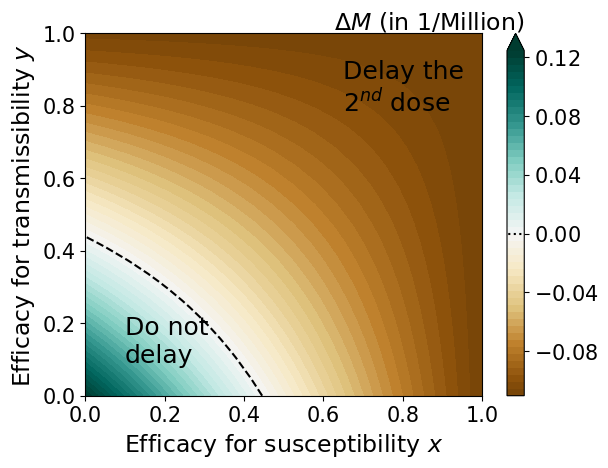

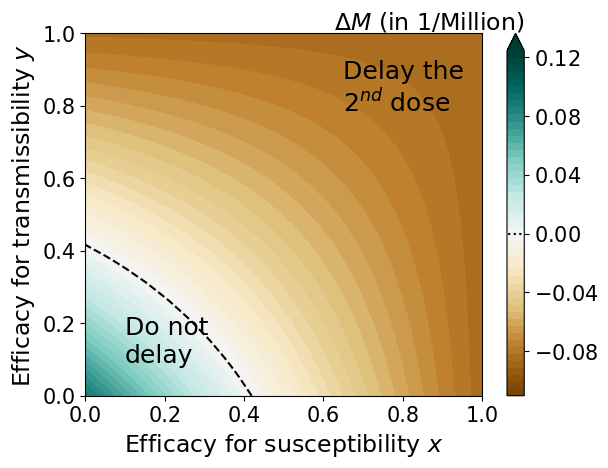

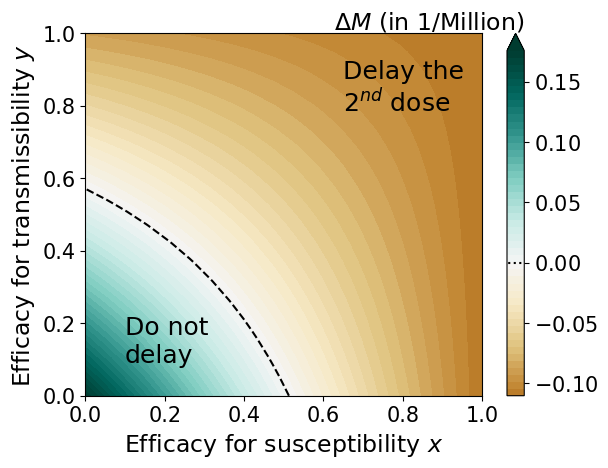

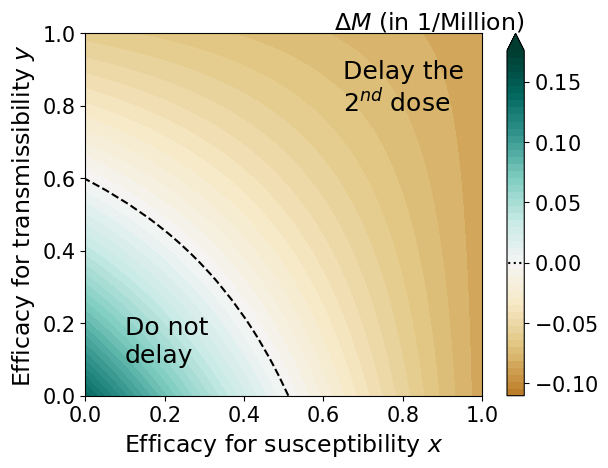

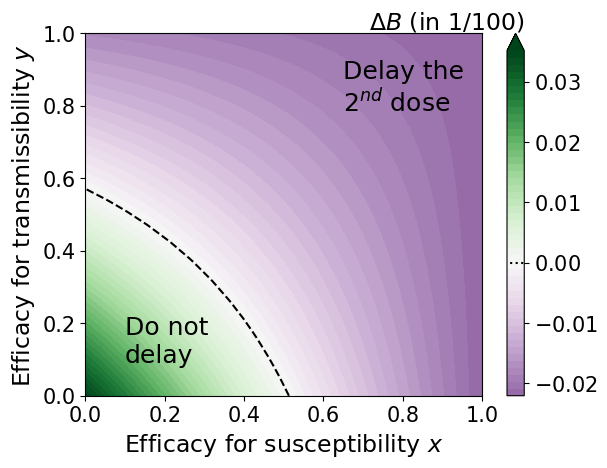

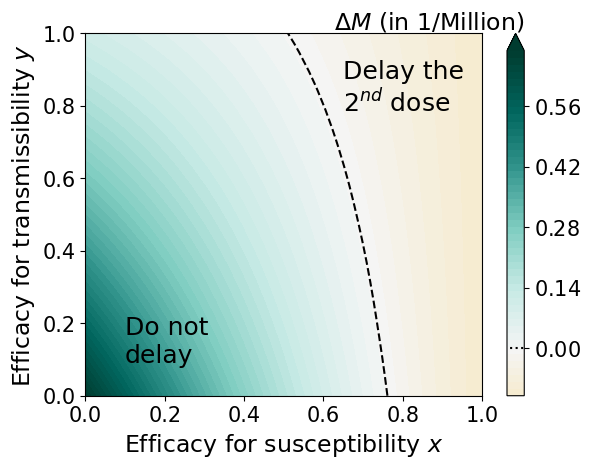

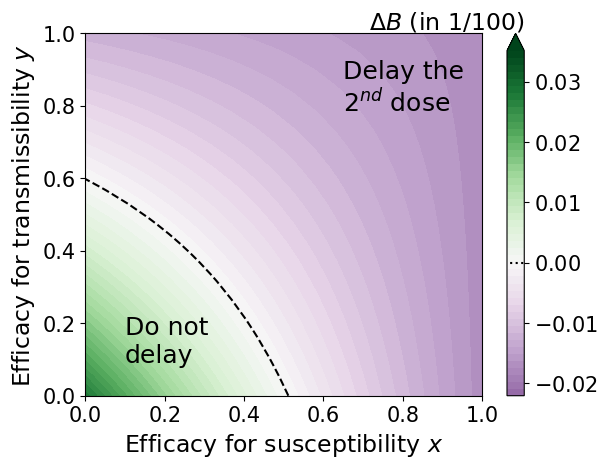

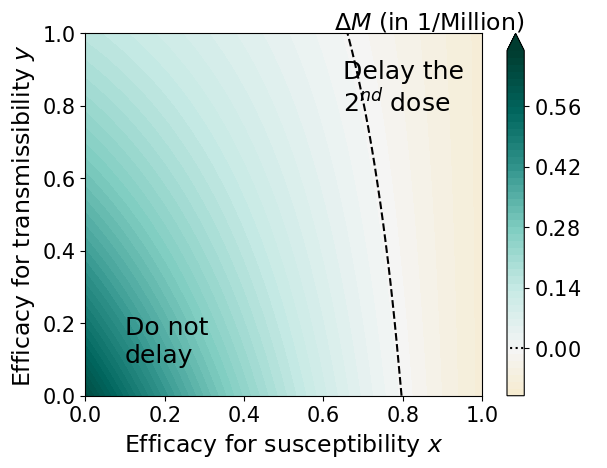

In [42]:
plot_heatmap_SEIR()

./Fig/SEIR/diff/mutants_MuRatio01_SIR_scenario2.pdf
./Fig/SEIR/diff/mutants_MuRatio01_SEIR_scenario2.pdf
./Fig/SEIR/diff/mutants_MuRatio1_SIR_scenario2.pdf
./Fig/SEIR/diff/mutants_MuRatio1_SEIR_scenario2.pdf
./Fig/SEIR/diff/burden_SIR_scenario2.pdf
./Fig/SEIR/diff/mutants_SIR_scenario2.pdf
./Fig/SEIR/diff/burden_SEIR_scenario2.pdf
./Fig/SEIR/diff/mutants_SEIR_scenario2.pdf


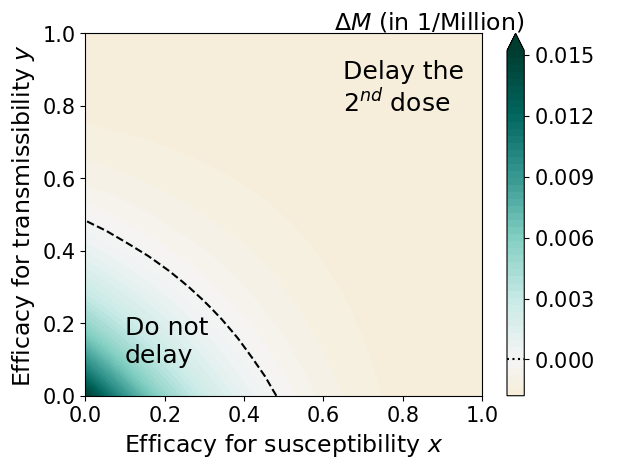

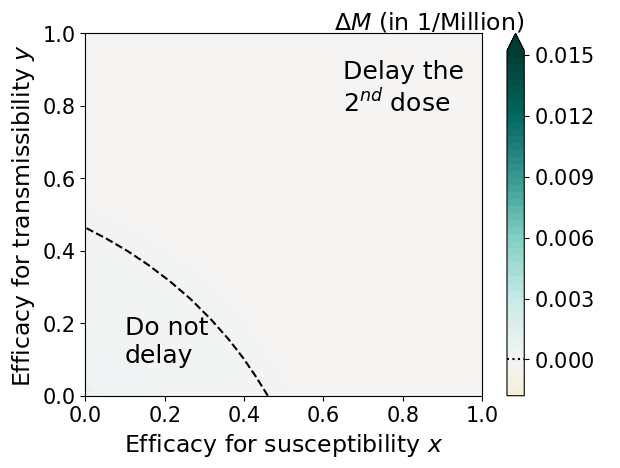

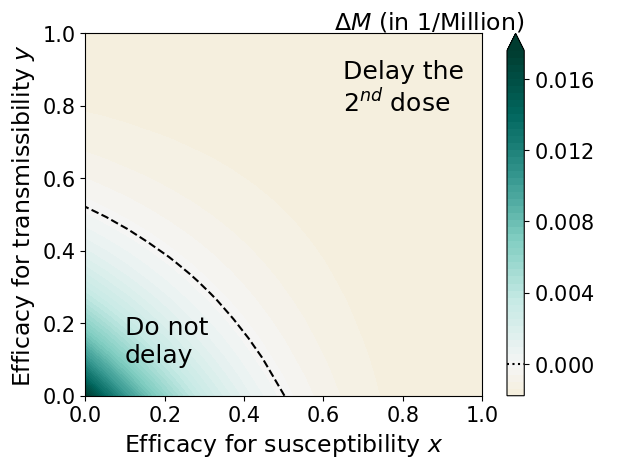

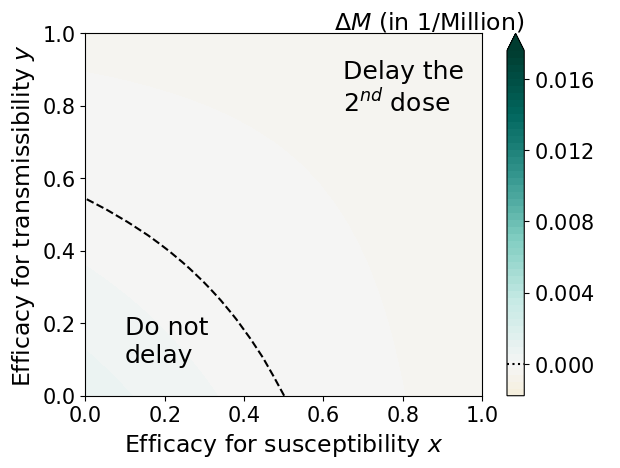

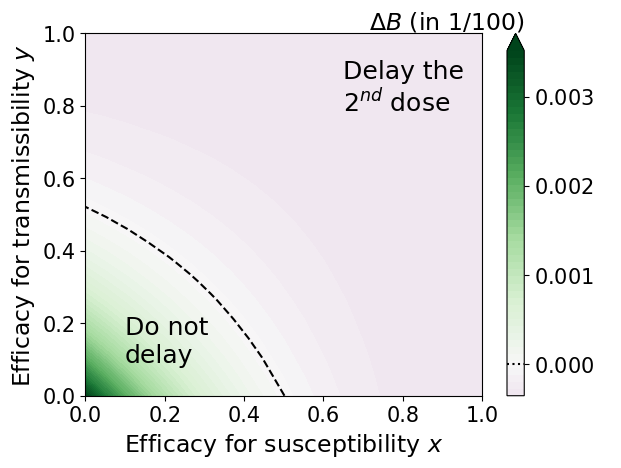

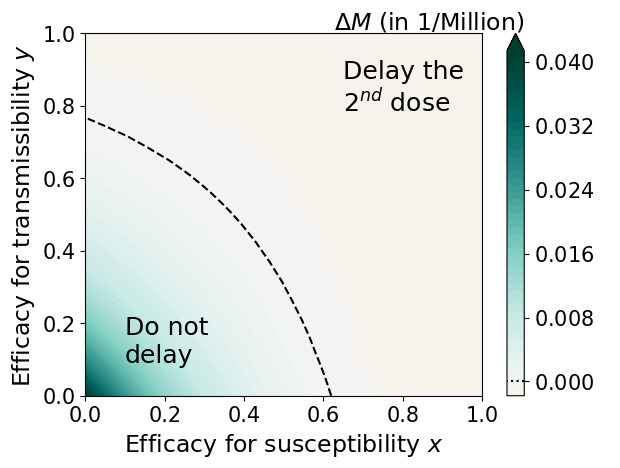

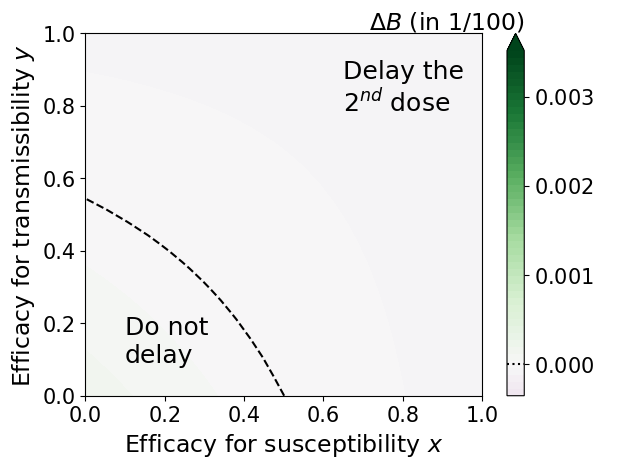

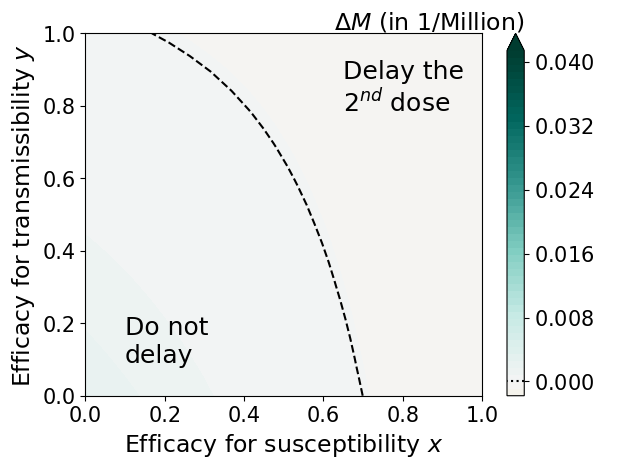

In [43]:
plot_heatmap_SEIR(I0=1e-6, Rec0=0, name="scenario2")